# pre

## import & setting

In [508]:
import anndata as ad
import scanpy as sc
import numpy as np
import seaborn as sns
import palettable
import scipy
import pandas as pd
import scipy.io as sio
import pickle
import sys
sys.path.append('/home/yzy/bioSIMS/code/analysis')
from utils_220 import *

sc.set_figure_params(dpi=500, color_map='viridis',dpi_save=500,transparent=True)
heatmap_cmp = palettable.cmocean.diverging.Balance_20.mpl_colormap
cls_cmp = palettable.cartocolors.qualitative.Bold_10.mpl_colors
# cls_cmp = palettable.cartocolors.qualitative.Safe_7.mpl_colors


## functions

In [12]:
def get_adj_matters(key_matters,matter_list):
    key_matters = np.array(key_matters).astype('float')
    matter_list = np.array(matter_list).astype('float')
    adjested_key_matters = []
    for k in key_matters:
        m_diff = np.abs(matter_list-k)
        min_diff_idx = np.argmin(m_diff)
        min_diff_m = matter_list[min_diff_idx]
        adjested_key_matters.append(min_diff_m)
    adjested_key_matters = np.array(adjested_key_matters)
    return adjested_key_matters

In [13]:
def add_subcls(a_cls_sub,ec_cls,to_replace_cls):
    a_cls_sub_int = a_cls_sub.astype('int')
    a_cls_sub_int[a_cls_sub_int==int(to_replace_cls)] = -1
    a_cls_sub_int[a_cls_sub_int>int(to_replace_cls)]-=1
    a_cls_sub_int_max = a_cls_sub_int.max()
    
    ec_cls_int = ec_cls.astype('int')
    ec_cls_int -= ec_cls_int.min()
    ec_cls_int+=(a_cls_sub_int_max+1)
    a_cls_sub_int[a_cls_sub_int==-1] = ec_cls_int
    return a_cls_sub_int.astype('str')

In [14]:
def ind2ij(ind,size,axis):
    i,j=divmod(ind-1,size)
    i+=1
    j+=1
    return np.array([i,j])[axis]



In [15]:
def get_train_data(data_mat_filename,mode,norm,batch_num_list=[1]):
#     mode分为:'none','median','total'
#     norm分为:'none',standard','l1','l2'
#     batch_num_list = [3,5]
    # 5行
    # 1,2,3,4,5,6
    # batch_num = 4


    original_data = {}
    cell_related_data = {}
    data_mat = sio.loadmat(data_mat_filename)
    data_mat=data_mat['data_mat']



    num_features = data_mat.shape[1]-3
    batch_dict = {}

    label_dict = {}
    cell_dict = {}
    pos_dict = {}

    for i in range(1):

            cur_data = data_mat[data_mat[:,0]==i+1,3:num_features+3]


            batch_dict[i+1] = cur_data

            cell_dict[i+1] = data_mat[data_mat[:,0]==i+1,1]
            cur_batch_idx = data_mat[data_mat[:,0]==i+1,2]
            label_dict[i+1] = np.ones(shape=cur_batch_idx.shape)


            pos_dict[i+1] = cur_batch_idx
    original_data['batch_dict'] = batch_dict
    original_data['cell_dict'] = cell_dict
    original_data['label_dict'] = label_dict
    original_data['pos_dict'] = pos_dict






    top_n_var = 250
    train_x_all = None
    cell_idx_all = None
    cell_type_all = None
    cell_pos_all = None
    batch_idx_all = None
    num_cells_all = 0


    for batch_num in batch_num_list:
        train_x = batch_dict[batch_num]
        # train_x = eval('batch_dict_{norm_type}[batch_num]'.format(norm_type=norm_type))
        # train_x = batch_dict[batch_num]
        cell_idx = cell_dict[batch_num]
        cell_type = label_dict[batch_num]
        cell_pos = pos_dict[batch_num]
        # batch_FE = FE_dict[batch_num]
        cell_related_ind = (cell_idx!=0)

        num_cells = int(np.max(cell_idx))
        # num_cells = 2
        train_x = train_x[cell_related_ind,:]

        cell_idx = cell_idx[cell_related_ind]
        cell_type = cell_type[cell_related_ind]
        # cell_type = np.ones(shape=cell_idx.shape)
        cell_pos = cell_pos[cell_related_ind]





        var_li = []
        normed_var_li = []
        for i in range(train_x.shape[1]):
            cur_col = train_x[:,i]
        #     cur_col= cur_row/np.sum(cur_col)
        #     cur_entropy = entropy(cur_col)
            cur_var = np.var(cur_col)
            cur_normed_var = cur_var/np.mean(cur_col)
        #     entropy_li.append(cur_entropy)
            var_li.append(cur_var)
            normed_var_li.append(cur_normed_var)
        # entropy_li = np.array(entropy_li)
        var_li = np.array(var_li)
        normed_var_li = np.array(normed_var_li)
        sort_ind = np.flip(np.argsort(normed_var_li),axis=0)
        sort_val = np.flip(np.sort(normed_var_li),axis=0)
        
        if train_x_all is None:
            train_x_all = train_x
        else:
            train_x_all = np.vstack([train_x_all,train_x])
        if cell_idx_all is None:
            cell_idx_all = cell_idx
        else:
            cell_idx_all = np.hstack([cell_idx_all,cell_idx+np.max(cell_idx_all)])
        if cell_type_all is None:
            cell_type_all = cell_type
        else:
            cell_type_all = np.hstack([cell_type_all,cell_type])
        if cell_pos_all is None:
            cell_pos_all = cell_pos
        else:
            cell_pos_all = np.hstack([cell_pos_all,cell_pos])
        if batch_idx_all is None:
            batch_idx_all = batch_num*np.ones(shape=(cell_idx.shape))
        else:
            batch_idx_all = np.hstack([batch_idx_all,batch_num*np.ones(shape=(cell_idx.shape))])


    train_x = train_x_all
    cell_idx = cell_idx_all
    cell_type = cell_type_all
    cell_pos = cell_pos_all
    batch_idx = batch_idx_all
    num_cells = np.max(cell_idx)
    if mode=='none':
        train_x = train_x
    elif mode=='median':
        train_x = train_x/np.percentile(train_x,50,axis=1,keepdims=True)
        train_x = np.log(train_x+1)
    elif mode=='total':
        train_x = train_x/np.sum(train_x,axis=1,keepdims=True)
        train_x = np.log(train_x+1)

    if norm=='standard':
        train_x = StandardScaler().fit_transform(train_x)
    elif norm=='l1':
        train_x = Normalizer(norm='l1').fit_transform(train_x)
    elif norm=='l2':
        train_x = Normalizer(norm='l2').fit_transform(train_x)
    elif norm=='none':
        train_x = train_x

    cell_related_data['train_x'] = train_x
    cell_related_data['cell_idx'] = cell_idx
    cell_related_data['cell_type'] = cell_type
    cell_related_data['cell_pos'] = cell_pos
    cell_related_data['batch_idx'] =batch_idx
    cell_related_data['num_cells'] = num_cells
    return original_data,cell_related_data



In [16]:
def get_labeling(label,cell_idx,cell_pos):
#     y是cell-rela的细胞对应的标签
#     print('pred_y',np.unique(label))
    labeling = np.zeros(shape=(65536,1))
    b = cell_idx.copy()
    num_cells = label.shape[0]
    for i in range(num_cells):
        b[b==i+1] = label[i] + 1
#     print(cell_pos)
#     print('b',np.unique(b))
#     cell_pos = cell_pos.astype('int')
    labeling[cell_pos.astype('int')-1,0] = b

    return labeling

In [17]:
def show_images(images, cols = 1, titles = None,cmps='jet'):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
#         print(cols)
#         cmp = cmps[n]
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
#         if image.ndim == 2:
#             plt.gray()
        
    
        plt.imshow(image,cmap=cmps)
        plt.xticks([])
        plt.yticks([])
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()
    

import matplotlib.pyplot as plt
# uh_pred = hdbscan.HDBSCAN(min_cluster_size=30).fit_predict(rep_embed)
# pred_y = np.ones(shape=(np.max(cell_idx)))
# pred_y = KMeans(3).fit_predict(sim_mat_bak)
# pred_y = SIMLR(sim_mat_bak,-8)
# pred_y = SpectralClustering(4,affinity='precomputed').fit_predict(sim_mat_order_bak)
# pred_y = AgglomerativeClustering(4,affinity='precomputed',linkage='complete').fit_predict(1/(input_sim_mat+1))
def plot_label_image(pred_y,cmp,save=None,mask=None):
    
    to_labeling_pred_y = np.array(pred_y.astype('int'))
    # to_labeling_pred_y[coc[448,:]>0]=3
    # to_labeling_pred_y = resultsLWEA[:,2]
    # to_labeling_pred_y = label_list_FF[2]
    # to_labeling_pred_y = label_list[3]
    # to_labeling_pred_y[mark_list]=2
#     cluster_cmp = sns.hls_palette(np.unique(to_labeling_pred_y).shape[0])
    unique_cls = np.unique(pred_y).shape[0]
    cluster_cmp = cmp.copy()
    
    if mask is not None:
        for to_mask in range(unique_cls):
            if to_mask in mask:
                continue
                
            cluster_cmp[to_mask]='k'
    labeling_plot_cmp = ['k']
    labeling_plot_cmp.extend(cluster_cmp)
    labeling = get_labeling(to_labeling_pred_y-np.min(to_labeling_pred_y),cell_idx,cell_pos)
    # labeling[labeling==5]=0
    img1 = labeling.reshape((256,256))
    plt.figure(figsize=(5,5))
    # plt.imshow(img1)
    ticks=np.arange(np.min(img1)+1,np.max(img1)+1)
    boundaries = np.arange(np.min(img1)+0.5,np.max(img1)+1.5)
#     with sns.plotting_context(font_scale=font_scale):
    sns.heatmap(img1,cmap=labeling_plot_cmp,linewidths=0,linecolor='k',square=True,cbar_kws={"ticks":ticks, "boundaries":boundaries,'fraction':0.046,'pad':0.04})
    # sns.heatmap(img1,cmap=labeling_plot_cmp,square=True,ad':0.04})
#     plt.legend(fontsize=font_size)
    plt.xticks([])
    plt.yticks([])
    if save is not None:
        plt.savefig(save,transparent=False,format='pdf',bbox_inches='tight')

#     for i in range(num_cells):
#         cur_idx = i + 1
#         cur_ind = cell_pos[cell_idx==cur_idx][0]
#     #     print(ind2ij(cur_ind,256,0))
#     #     print(ind2ij(cur_ind,256,1))

#         plt.annotate(str(cur_idx-1),(ind2ij(cur_ind,256,1),ind2ij(cur_ind,256,0)),color='red')

   
    plt.show()
    
    
    
    
def plot_label_image(pred_y,cmp,save=None,mask=None,figsize=(5,5),anno=False,ifshow=True):
    
    to_labeling_pred_y = np.array(pred_y.astype('int'))
    to_labeling_pred_y_min = to_labeling_pred_y.min()
    # to_labeling_pred_y[coc[448,:]>0]=3
    # to_labeling_pred_y = resultsLWEA[:,2]
    # to_labeling_pred_y = label_list_FF[2]
    # to_labeling_pred_y = label_list[3]
    # to_labeling_pred_y[mark_list]=2
#     cluster_cmp = sns.hls_palette(np.unique(to_labeling_pred_y).shape[0])
    unique_cls = np.unique(pred_y).shape[0]
#     unique_cls_mask = [unique_cls[m] for m in mask]
    cluster_cmp = cmp.copy()
    
    if mask is not None:
        for to_mask in range(unique_cls):
            if to_mask in mask:
                continue
#             print(type(cluster_cmp))
#             print(to_mask,cluster_cmp)
            cluster_cmp[to_mask]='k'
    labeling_plot_cmp = ['k']
    labeling_plot_cmp.extend(cluster_cmp)
    labeling = get_labeling(to_labeling_pred_y-np.min(to_labeling_pred_y),cell_idx,cell_pos)
    # labeling[labeling==5]=0
    img1 = labeling.reshape((256,256))
    plt.figure(figsize=figsize)
    # plt.imshow(img1)
    ticks=np.arange(np.min(img1)+1,np.max(img1)+1)
    boundaries = np.arange(np.min(img1)+0.5,np.max(img1)+1.5)
#     with sns.plotting_context(font_scale=font_scale):
    sns.heatmap(img1,cmap=labeling_plot_cmp,linewidths=0,linecolor='k',square=True,cbar_kws={"ticks":ticks, "boundaries":boundaries,'fraction':0.046,'pad':0.04})
    # sns.heatmap(img1,cmap=labeling_plot_cmp,square=True,ad':0.04})
#     plt.legend(fontsize=font_size)
    plt.xticks([])
    plt.yticks([])
    if save is not None:
        plt.savefig(save,transparent=False,format='png',bbox_inches='tight')

    if anno:
        num_cells = pred_y.shape[0]
        for i in range(num_cells):
            cur_idx = i + 1
            cur_ind = cell_pos[cell_idx==cur_idx][0]
        #     print(ind2ij(cur_ind,256,0))
        #     print(ind2ij(cur_ind,256,1))
            if to_labeling_pred_y[i]-to_labeling_pred_y_min in mask:
                plt.annotate(str(cur_idx-1),(ind2ij(cur_ind,256,1),ind2ij(cur_ind,256,0)),color='red')

    if ifshow:
        plt.show()

# experiment

## de novo SEAM

### load SIMS data

In [9]:
1+1

2

In [458]:
data_mat_filename_temp = '/home/yzy/bioSIMS/data/process/{0}/cut/rst/datamat.mat'
matter_list_filename_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/matters_candidate.pkl'

# data = 'SPE1'
# test_sample_temp = '/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_718.mat'




# data='191125_gastric_div15_None_ada'
# test_sample_temp = '/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_269.mat'


# data='20190115_liverfiber1_filter'
# test_sample_temp = '/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_198.mat'
# data='liver_hoechst_blood_ada'
# test_sample_temp = '/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_114.mat'
# data = '20190303_liverfiber_fix'
# data = '20190308_liver_P1LF2_2'

# data = 'P3_low_1_ada'
# test_sample_temp = '/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_621.mat'
# data = 'P3_high_2_ada'
# test_sample_temp = '/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_238.mat'

# data='liver-xwh-2-1'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_286.mat'

# data='SPE1'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_286.mat'

# data='20190103_lung3_filter'
# test_sample_temp = '/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_164.mat'

# data='20190117_liverfiber2_pos'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_209.mat'


# data='P4_low0_ada'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_793.mat'


# data='20190117_liverfiber2_pos'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_209.mat'

# data='rat0_low0_auto'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_699.mat'


# data='20190117_liverfiber2_pos_gaussian_ada'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_209.mat'

# data = 'P5LC_POS1_HIGH0_None_ada'
# test_sample_temp = '/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_196.mat'

# data='mouse0_liver0_neg0_high0_div15_None_ada'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_224.mat'

# data='mouse0_lung0_neg0_high0_div10_None_ada'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_225.mat'


# data='mouse0_lung0_pos0_high0_div10_None_ada'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_193.mat'


# data='mouse0_liver0_neg1_high0_5_None_ada'
# data='mouse0_liver0_neg1_high0_None_ada'
# # # # data='mouse0_liver0_neg1_high0_5_None_auto'
# data='mouse0_liver0_neg1_high0_div15_gaussian_ada'
# data='mouse0_liver0_neg1_high0_div15_None_ada'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_244.mat'

# data = 'PCs/mouse0_liver0_neg0_low_PC0_div20_None_auto'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_659.mat'
 
# data = 'mouse0_liver0_neg2_high0_None_auto'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_244.mat'



# data = 'mouse0_liver0_neg2_high0_None_ada'
# test_sample_temp = '/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_244.mat'


# data='mouse0_kidney0_neg0_high0_20_None_auto'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_221.mat'

# data='mouse0_liver0_pos1_high1_None_ada'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_200.mat'

# data='mouse0_liver0_neg1_low0_div10_None_ada'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_691.mat'

# data = 'P6_neg0_low0_None_auto'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_231.mat'


# data = 'P6_neg1_low0_None_auto'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_228.mat'

# data = '20190103_intestine1_all'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_262.mat'
# intestine_ada

# data = 'intestine-1'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_194.mat'
# data = 'intestine'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_185.mat'

# ！！
# data = '20190103_intestine2_filter_auto'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_181.mat'
# !!
# data = 'mix_cancer_idu_normal_gaussian_ada'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_168.mat'


# !!
data = 'mix_AB_H_gaussian_auto'
test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_274.mat'


# data = '20190103_intestine1_filter_auto'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_202.mat'


# !!
# data = '20190103_lung3_filter'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_164.mat'
# data = 'mouse0_lung0_neg0_high0_div15_None_ada'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_225.mat'

# !!
# data = 'mouse0_kidney0_neg0_high0_20_None_auto'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_221.mat'

# data = '20190115_liverfiber2_filter'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_191.mat'






matter_list_filename = matter_list_filename_temp.format(data)
data_mat_filename = data_mat_filename_temp.format(data)
test_sample_filename = test_sample_temp.format(data)
test_sample_all = sio.loadmat(test_sample_filename)['test_samples']
mode='none'
norm='none'
[original_data,cell_related_data]=get_train_data(data_mat_filename,mode,norm,batch_num_list=[1])
train_x=cell_related_data['train_x']
cell_idx=cell_related_data['cell_idx']
cell_pos=cell_related_data['cell_pos']
num_cells = np.max(cell_idx)
matter_list = pickle.load(open(matter_list_filename,'rb'))
matter_list = np.array(matter_list)

### normalize SIMS data

In [401]:
train_x_tmp = train_x.copy()

In [402]:
train_x_median = (train_x_tmp+1)/(np.percentile(train_x_tmp,50,axis=1,keepdims=True)+1)
train_x_total = train_x/np.sum(train_x,axis=1,keepdims=True)
train_x_median = np.log(train_x_median+1)
train_x_total = np.log(train_x_total+1)
# train_x_A = (train_x+1)/(train_x[:,matter_list==134.06]+1)
sum_profile_list_median = []
sum_profile_list_total = []

max_profile_list_median = []
max_profile_list = []
mean_profile_list_median = []
max_profile_list_total = []
mean_profile_list_total = []
mean_profile_list=[]
# mean_profile_list_A=[]
# max_profile_list_A = []
for i in range(num_cells):
        mean_profile_list_median.append(np.mean(train_x_median[cell_idx==i+1,:],axis=0))
        max_profile_list_median.append(np.max(train_x_median[cell_idx==i+1,:],axis=0))
        max_profile_list.append(np.max(train_x[cell_idx==i+1,:],axis=0))
#         mean_profile_list_A.append(np.mean(train_x_A[cell_idx==i+1,:],axis=0))
#         max_profile_list_A.append(np.max(train_x_A[cell_idx==i+1,:],axis=0))
        
        sum_profile_list_median.append(np.sum(train_x_median[cell_idx==i+1,:],axis=0))
        mean_profile_list.append(np.mean(train_x[cell_idx==i+1,:],axis=0))
        mean_profile_list_total.append(np.mean(train_x_total[cell_idx==i+1,:],axis=0))
        max_profile_list_total.append(np.max(train_x_total[cell_idx==i+1,:],axis=0))
        sum_profile_list_total.append(np.sum(train_x_total[cell_idx==i+1,:],axis=0))
        
mean_profile_list_median = np.array(mean_profile_list_median)
max_profile_list_median = np.array(max_profile_list_median)
mean_profile_list_total = np.array(mean_profile_list_total)
max_profile_list_total = np.array(max_profile_list_total)
sum_profile_list_median = np.array(sum_profile_list_median)
sum_profile_list_total = np.array(sum_profile_list_total)
mean_profile_list = np.array(mean_profile_list)
max_profile_list = np.array(max_profile_list)
# mean_profile_list_A = np.array(mean_profile_list_A)
# max_profile_list_A = np.array(max_profile_list_A)

### run SIMS-ID

In [432]:


SIMS_id_t_list = [5,10,15,20,25,30,35,40,50]



HEG_list = matter_list
# HEG_list = key_matters
# HEG_list = get_adj_matters(key_matters,matter_list)


HEG_col_idx = [list(matter_list).index(HEG) for HEG in HEG_list]

# netwidths=[128,128,128]
netwidths=[20,20,20]


error_threshold=0
train_x_HEG = train_x_tmp[:,HEG_col_idx]
train_x_preprocess = train_x_HEG
# train_x_preprocess = (train_x_HEG+1)/(train_x_HEG[:,matter_list==133.92]+1)

train_x_preprocess = (train_x_HEG)/np.sum(train_x_HEG,axis=1,keepdims=True)
# train_x_preprocess = (train_x_HEG+1)/(np.percentile(train_x_HEG,50,axis=1,keepdims=True)+1)




# train_x_preprocess = MinMaxScaler().fit_transform(train_x_preprocess)
# train_x_preprocess = np.log(train_x_preprocess+1)

# train_x_preprocess = train_x_preprocess-train_x_preprocess.mean(axis=0)
# U, s, V = np.linalg.svd(train_x_preprocess, full_matrices=False)
# train_x_preprocess = np.dot(U, np.diag(s))[:,:50]

# noise_matrix = np.random.rand(train_x_preprocess.shape[0],train_x_preprocess.shape[1])
# noise_matrix = np.ones_like(train_x_preprocess)
# train_x_preprocess = np.hstack([train_x_preprocess,noise_matrix])


rep_list = get_distil_rep(train_x_preprocess,cell_idx,num_cells,SIMS_id_t_list, verbose=False,epochs=20,netwidths=netwidths,low_dim=netwidths[2],error_threshold=error_threshold)


/home/yzy/anaconda3/envs/scaden/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/20
986/986 [==============================] - 1s 653us/step - loss: 4.0244 - softmax_loss: 4.0244 - center_loss: 0.0175
Epoch 2/20
986/986 [==============================] - 0s 104us/step - loss: 4.0214 - softmax_loss: 4.0212 - center_loss: 0.0216
Epoch 3/20
986/986 [==============================] - 0s 89us/step - loss: 4.0143 - softmax_loss: 4.0147 - center_loss: 0.0362
Epoch 4/20
986/986 [==============================] - 0s 97us/step - loss: 3.9985 - softmax_loss: 3.9974 - center_loss: 0.0804
Epoch 5/20
986/986 [==============================] - 0s 97us/step - loss: 3.9685 - softmax_loss: 3.9690 - center_loss: 0.2268
Epoch 6/20
986/986 [==============================] - 0s 117us/step - loss: 3.9172 - softmax_loss: 3.9138 - center_loss: 0.6294
Epoch 7/20
986/986 [==============================] - 0s 90us/step - loss: 3.8650 - softmax_loss: 3.8571 - center_loss: 1.4793
Epoch 8/20
986/986 [==============================] - 0s 129us/step - loss: 3.8412 - softmax_loss: 3.8359 - 

### run SIMLR

In [437]:
# rep = rep_list[0]
# rep = rep_list[0]
# from sklearn.manifold import tsne
# #PCA预处理
# rep_preprocess = np.log(rep+1)
# rep_preprocess = rep_preprocess-rep_preprocess.mean(axis=0)
# U, s, V = np.linalg.svd(rep_preprocess, full_matrices=False)
# rep_preprocess = np.dot(U, np.diag(s))[:,:50]
#PCA预处理
# rep_preprocess = rep

# rep_preprocess = rep_list[0][:,0][:,None]

# rep_embed = umap.UMAP(n_neighbors=30,min_dist=0).fit_transform(rep_preprocess)
# rep_embed = fast_tsne(rep_preprocess,perplexity=20)

# input_sim = sim_mat_order
# input_dist = 1/(1+input_sim)

# input_dist = (sim_mat+np.transpose(sim_mat))/2
# input_dist = squareform(pdist(rep_list[4]))
# input_dist = input_sim_mat
import SIMLR
input_rep = rep_list[0]
# input_rep = SIMLR.helper.fast_pca(input_rep,100)
# input_rep = mean_profile_list_median

input_dist = squareform(pdist(input_rep,'cosine'))
# input_dist = rodist_mat_asy
# input_dist = -SSA_dist
# input_dist = 1-LWCM_np
# input_dist = dist_mat[list(matter_list).index(114.91),:,:]
# input_dist = test_mat
# input_dist = 1-A
# input_dist = sim_mat_median_sym
# input_dist = squareform(pdist(mean_profile_list_median))
# rep_embed = umap.UMAP(metric='precomputed',n_neighbors=30,n_components=2).fit_transform(input_dist,pseudo_y)
rep_embed = umap.UMAP(metric='precomputed',n_neighbors=30,n_components=2).fit_transform(input_dist)
# c, num_clust, req_c = FINCH(input_rep, initial_rank=None, req_clust=3, distance='cosine', verbose=True)
# rep_embed = phate.PHATE(knn=10, decay=100,knn_dist='precomputed').fit_transform(input_dist)
# rep_embed = TSNE(metric='precomputed').fit_transform(input_dist)
# pred_y = hdbscan.HDBSCAN(min_cluster_size=20,min_samples=5,metric='precomputed').fit_predict(input_dist)
pred_y = KMeans(2).fit_predict(rep_embed)
# pred_y = pseudo_y
# pred_y = RMKKM(input_rep,3.0)
# [pred_y,A] = SLKE(rep_embed,2)
# [pred_y,A] = SSR(rep_embed,2)
# pred_y[mark_list]=np.max(pred_y)+1
# pred_y = pseudo_y

# c=2
# start_main = time.time()
# simlr = SIMLR.SIMLR_LARGE(c, 5, 0); ###This is how we initialize an object for SIMLR. the first input is number of rank (clusters) and the second input is number of neighbors. The third one is an binary indicator whether to use memory-saving mode. you can turn it on when the number of cells are extremely large to save some memory but with the cost of efficiency.
# S, F,val, ind = simlr.fit(input_rep)
# print('Successfully Run SIMLR! SIMLR took %f seconds in total\n' % (time.time() -         start_main))
# pred_y = simlr.fast_minibatch_kmeans(F,c)




# pred_y,A = SIMLR(input_rep,5)
# pred_y = req_c
# pred_y = c[:,3]
# pred_y = label_list[0]
# pred_y = pred_y_DB
# pred_y = KMeans(4).fit_predict(rep_list[3])
cluster_cmp = sns.hls_palette(np.unique(pred_y).shape[0])
labeling_plot_cmp = ['k']
labeling_plot_cmp.extend(cluster_cmp)
# mean_profile_list_median_preprocess = mean_profile_list_median-mean_profile_list_median.mean(axis=0)
# U, s, V = np.linalg.svd(mean_profile_list_median_preprocess, full_matrices=False)
# mean_profile_list_median_preprocess = np.dot(U, np.diag(s))[:,:50]
# umap_median_mean = umap.UMAP().fit_transform(mean_profile_list_median_preprocess)
# umap_median_mean = fast_tsne(mean_profile_list_median_preprocess,perplexity=50)
# fast_tsne(X50, perplexity=50, seed=42)

# X = X - X.mean(axis=0)
# U, s, V = np.linalg.svd(X, full_matrices=False)
# X50 = np.dot(U, np.diag(s))[:,:50]
# umap_median_mean = 
# scatter_pd_data = {
#     'x':[],
#     'y':[],
#     'i':[],
    
# }
# for i in range(num_cells):
#     cur_x = rep_embed[i,0]
#     cur_y = rep_embed[i,1]
#     cur_idx = i
#     scatter_pd_data['x'].append(cur_x)
#     scatter_pd_data['y'].append(cur_y)
#     scatter_pd_data['i'].append(cur_idx)
#     for matter in matter_list:
#         cur_profile = mean_profile_list_median[i,matter_list==matter][0]
# #         print(cur_profile)
#         if not scatter_pd_data.get(matter):
#             scatter_pd_data[matter]=[cur_profile]
#         else:
#             scatter_pd_data[matter].append(cur_profile)

# scatter_pd = pd.DataFrame(scatter_pd_data)
            
# scatter_pd['mark'] = pd.Series(np.zeros(shape=(scatter_pd.shape[0])),index=scatter_pd.index)


# mark_list = [284,260,275,267,310,335,373,378,383,382,380,377,365,340,322,309,212,224,139,341,535,51,
# 303,232,212,188,213,200,346,634,535,693,691,442,25,28,2,233,234,298,278,302,428,450]
# fix
# mark_list = [391,403,376,397,357,367]

# liverfiber1
# mark_list = [404,443,428,430,448,449,450,463,464]

# liverfiber1
# mark_list = [404,443,428,448,449,463]
# mark_list = [404,443,428,448,449,463]

# SPE1
# mark_list = [140,146]


# lung
# mark_list=[155,138,145,156,139,131,136]


# for ml in mark_list:
#     scatter_pd.loc[scatter_pd.i==ml,['mark']]=1
         

### create anndata

In [520]:
tissue_name = 'mix_cancer'

a_cancer = ad.read_h5ad('/home/yzy/ipynbs/figures/Supp/{0}/data.h5py'.format(tissue_name))


In [459]:
import anndata as ad
# mean
# in_X =  rep_list[3]
in_X = mean_profile_list_median
# g = map(str,range(in_X.shape[1]))

# matter_list = matter_list.astype('int')

g = map(str,matter_list)
Genes = []
None_idx = 0
Genes = g
# obs_name must be str
obs_name = list(map(str,range(in_X.shape[0])))
obs = pd.DataFrame(index=obs_name)

# var_name must be str
var = pd.DataFrame(index=Genes)

#     var['Genes'] = Genes
a = ad.AnnData(in_X,  obs=obs,var=var, dtype='float32')
a.uns['rep_list'] = rep_list



In [449]:
a.var_names_make_unique()

AnnData object with n_obs × n_vars = 540 × 164 
    uns: 'rep_list'

In [468]:
cur_exp_name = 'cls_2'
tissue_name = 'mix_ABH'
a.obsm['X_umap'] = rep_embed
a.obs[cur_exp_name] =pred_y.astype('int').astype('str')
a.obs[cur_exp_name] = a.obs[cur_exp_name].astype('category')
a.obsm[cur_exp_name+'_rep'] = input_rep.copy()
# a.uns[cur_exp_name+'_colors'] = [cls_cmp[3],cls_cmp[5],cls_cmp[7],cls_cmp[4]]
a.uns[cur_exp_name+'_colors'] = ['r','#13F4EF']

### scanpy ploting

In [91]:
np.unique(a.obs['cls_5_reorder'])

array(['1', '2', '3', '4', '5', '6'], dtype=object)

In [93]:
a.uns['cls_5_reorder_colors'] = np.array([[0.49803922, 0.23529412, 0.55294118],
       [0.06666667, 0.64705882, 0.4745098 ],
       [0.94901961, 0.71764706, 0.00392157],
       [0.90196078, 0.51372549, 0.0627451 ],
       [0.        , 0.5254902 , 0.58431373],
       [0.90588235, 0.24705882, 0.45490196]])

In [410]:
a.uns['leiden_colors'] = ['#13F4EF','r']

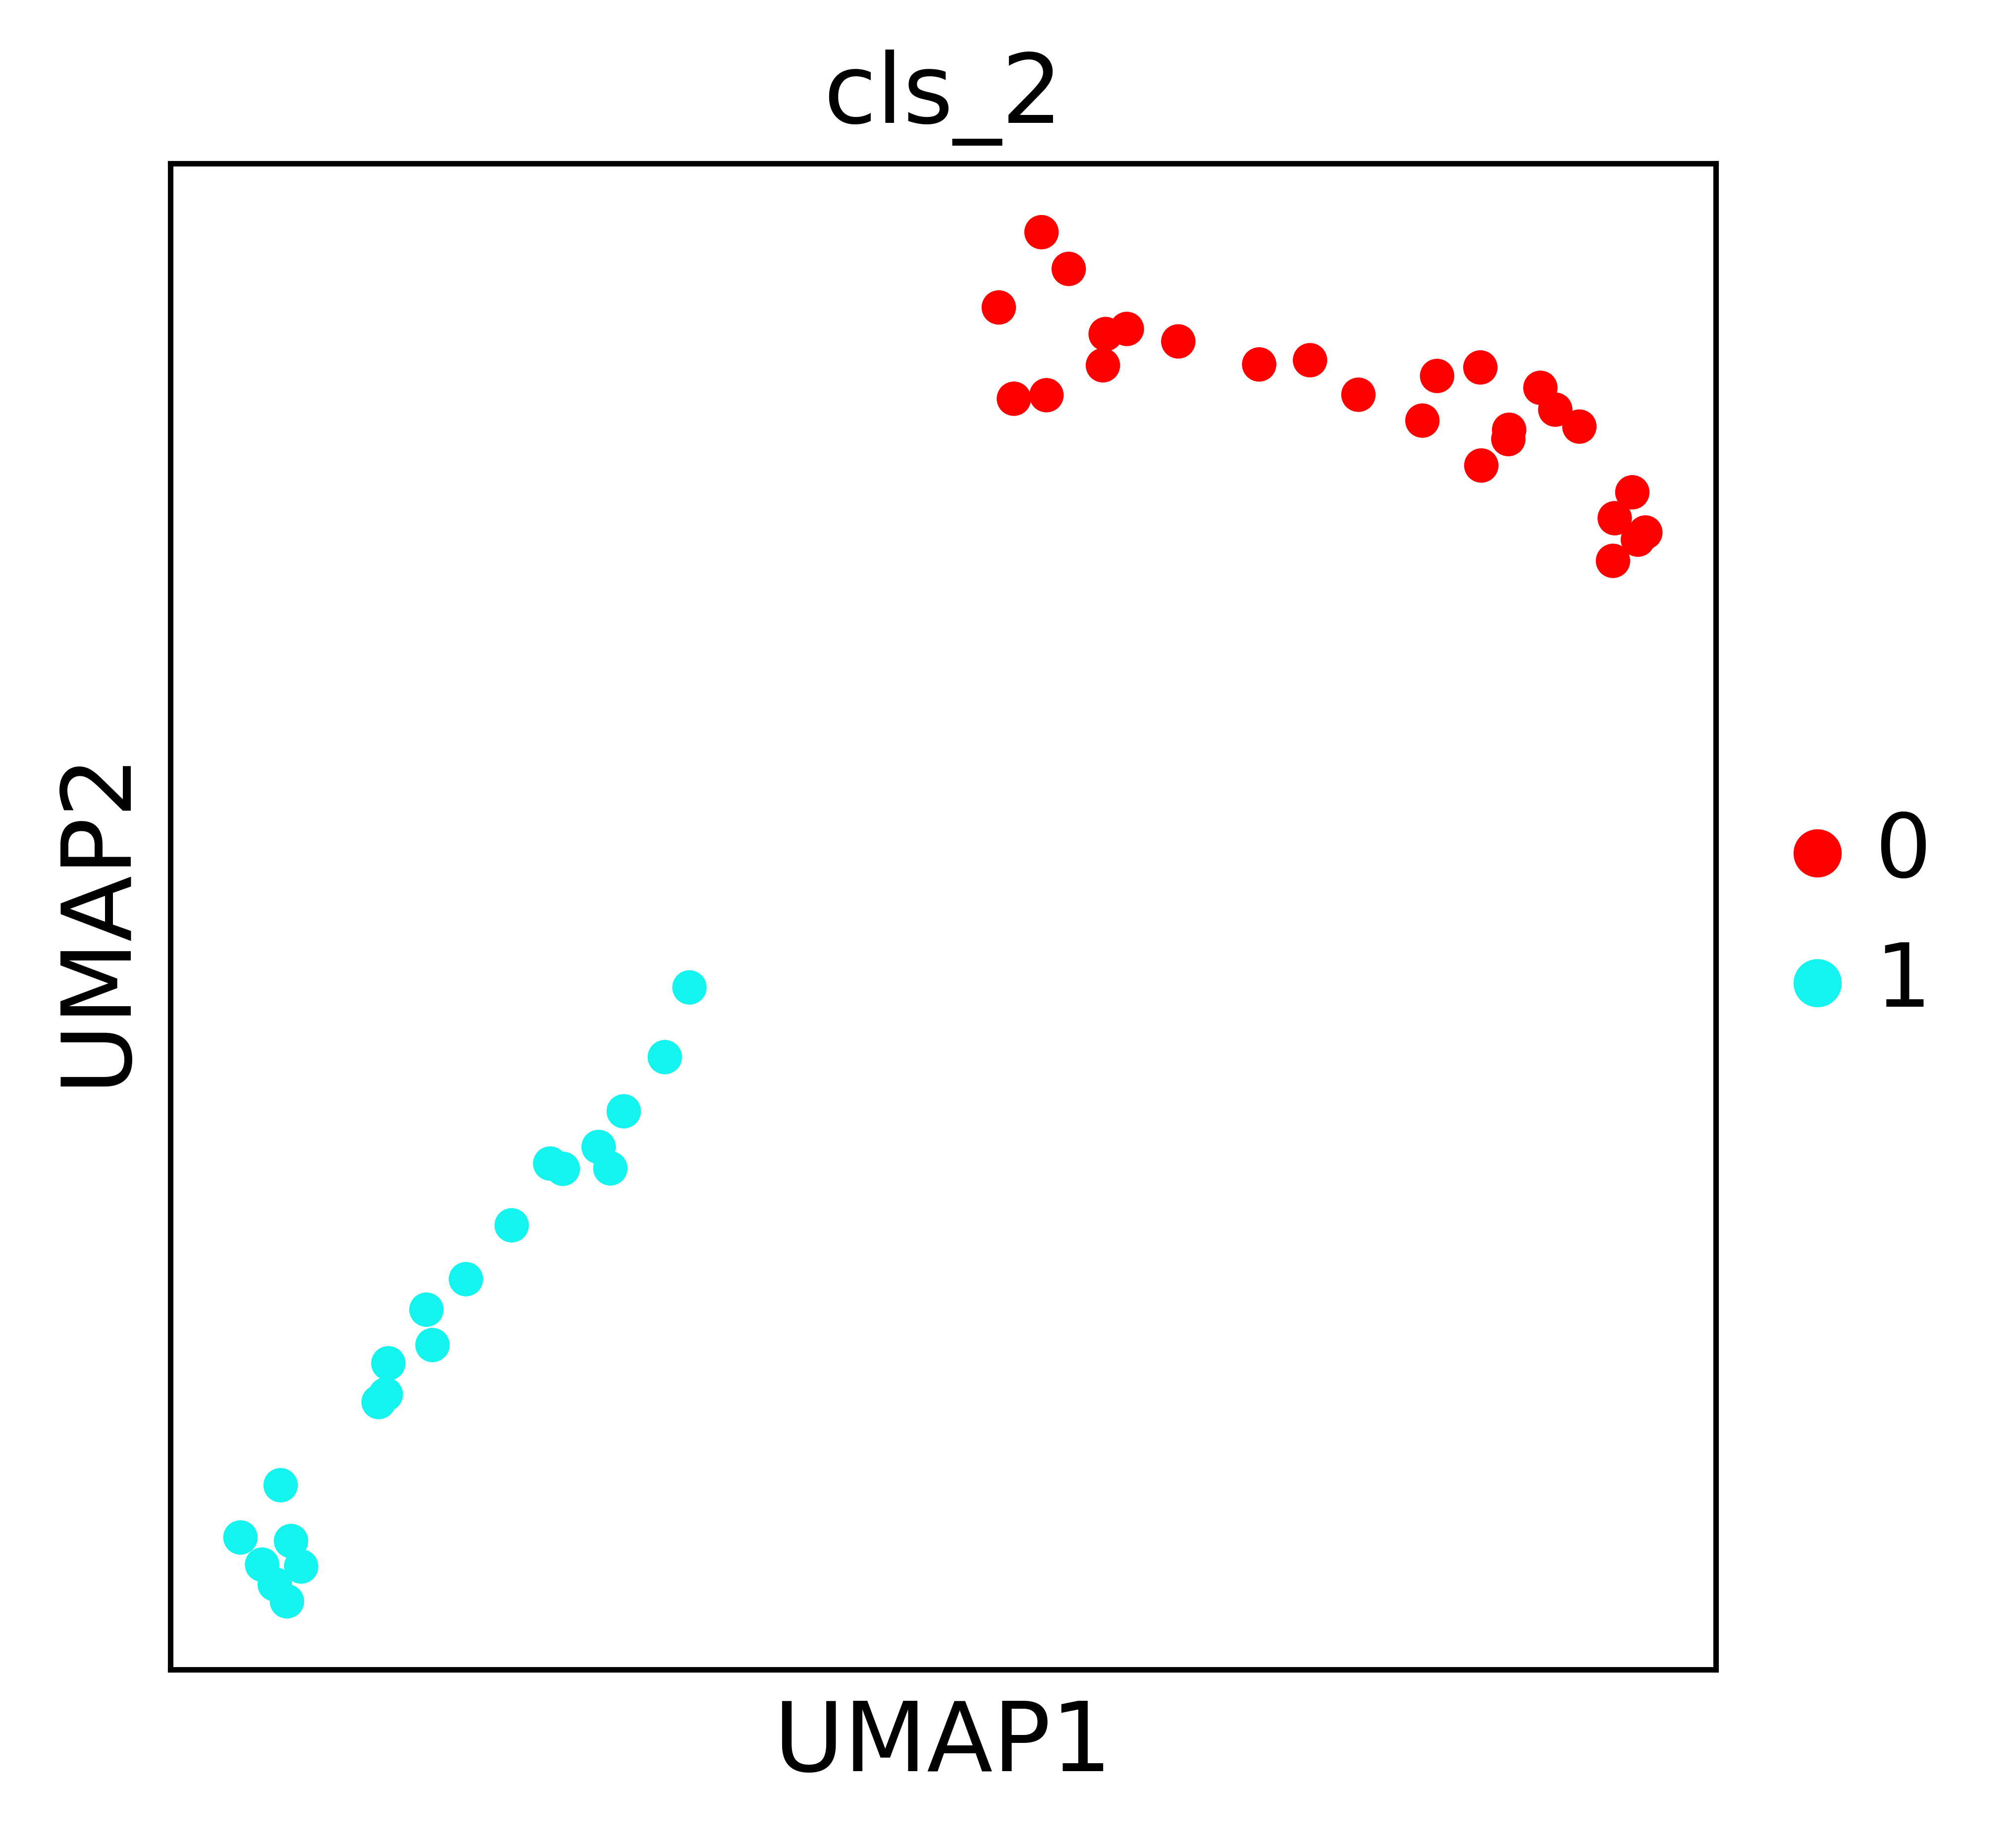

In [526]:
sc.settings.figdir = 'figures/Supp/{0}/'.format(tissue_name)
save_umap = '.png'

sc.pl.umap(a_bak_adj,color='cls_2',s=100,save=save_umap)

computing neighbors
    finished (0:00:00)
running Leiden clustering
    finished (0:00:00)
computing UMAP
    finished (0:00:00)


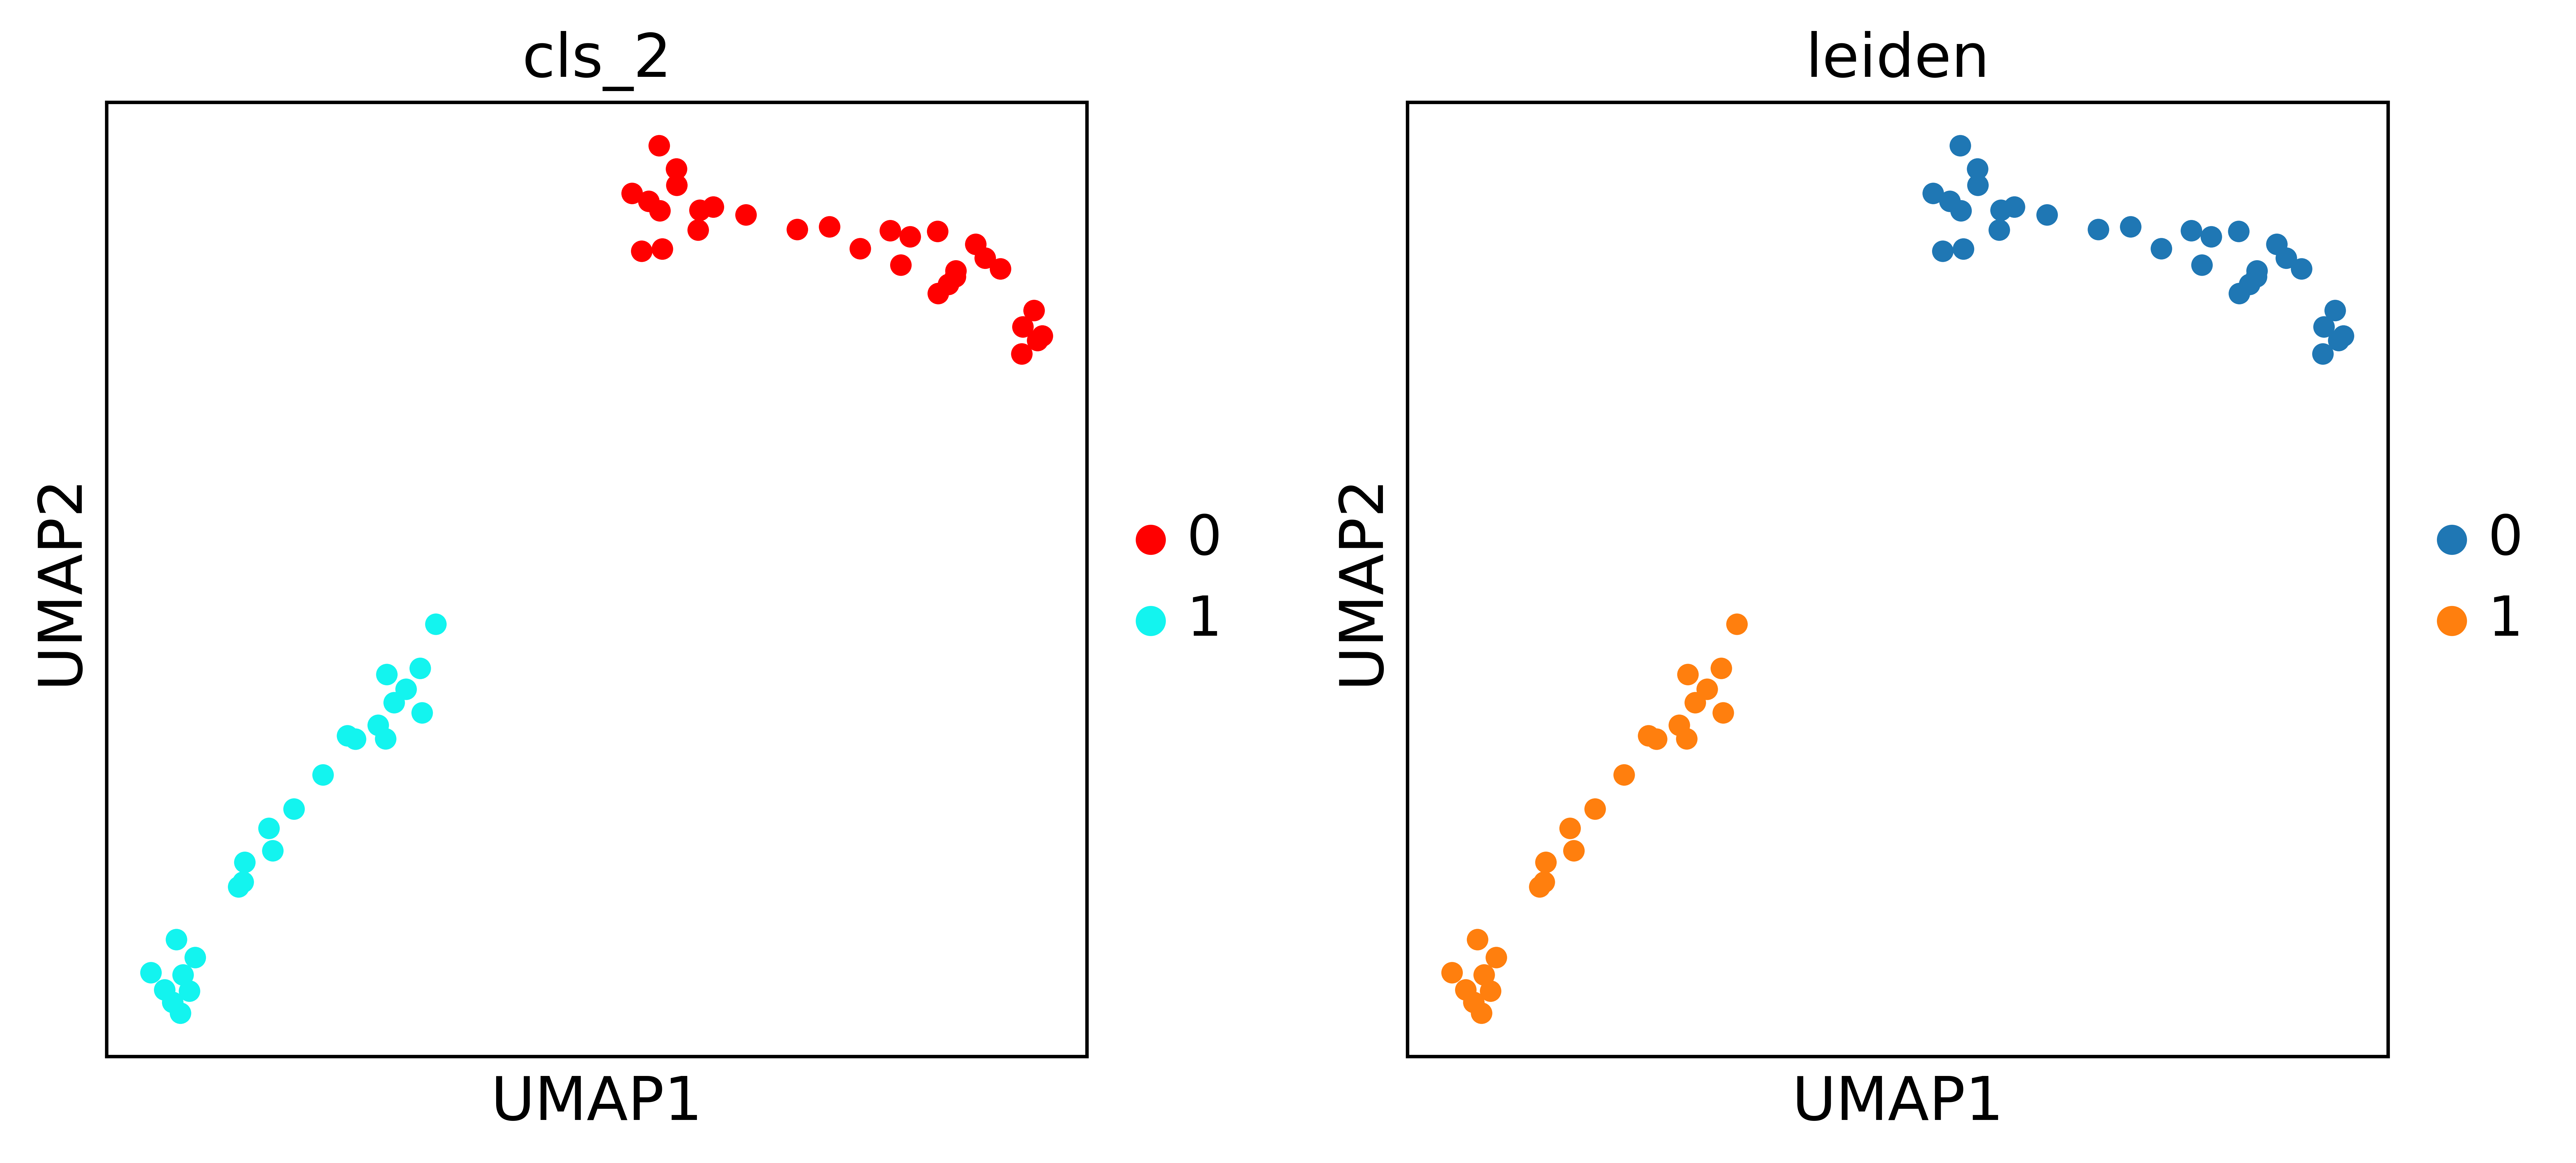

In [469]:
sc.settings.figdir = 'figures/Supp/{0}/'.format(tissue_name)
save_umap = '.png'

sc.pp.neighbors(a,use_rep=cur_exp_name+'_rep',metric='cosine',n_neighbors=30)
sc.tl.leiden(a,resolution=0.1)
sc.tl.umap(a,min_dist=0,)

sc.pl.umap(a,color=[cur_exp_name,'leiden'],s=100,save=save_umap)

NameError: name 'a' is not defined

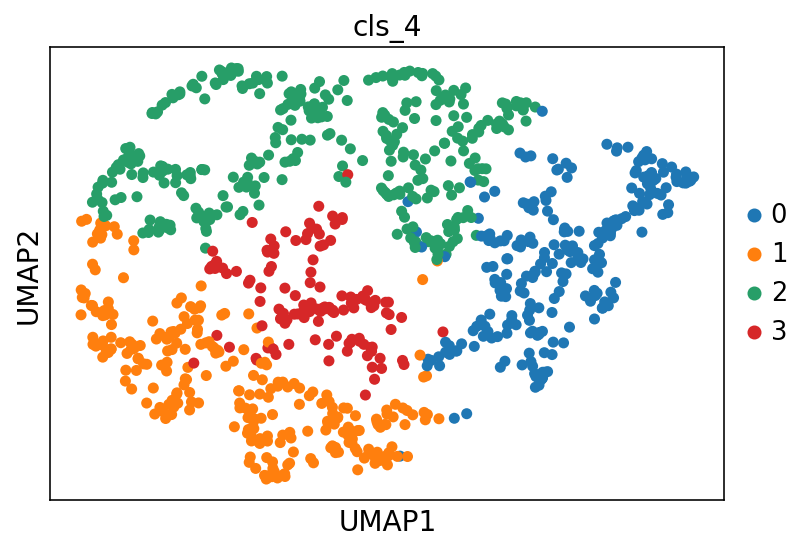

In [124]:
sc.pl.umap(a,color=[cur_exp_name,])

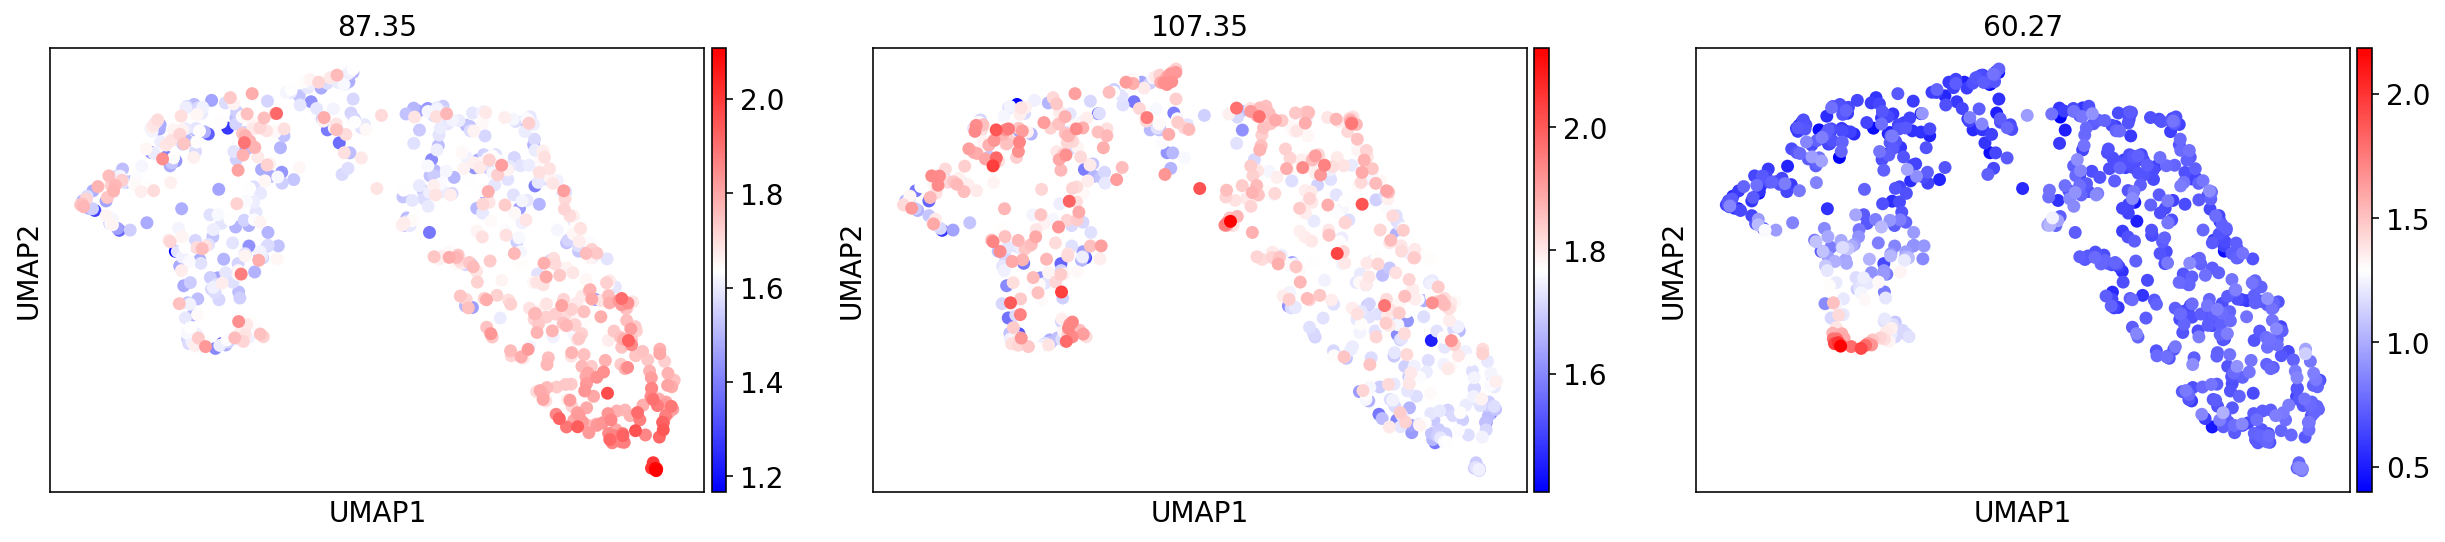

In [43]:
sc.pl.umap(a,color=['87.35','107.35','60.27'],cmap='bwr')


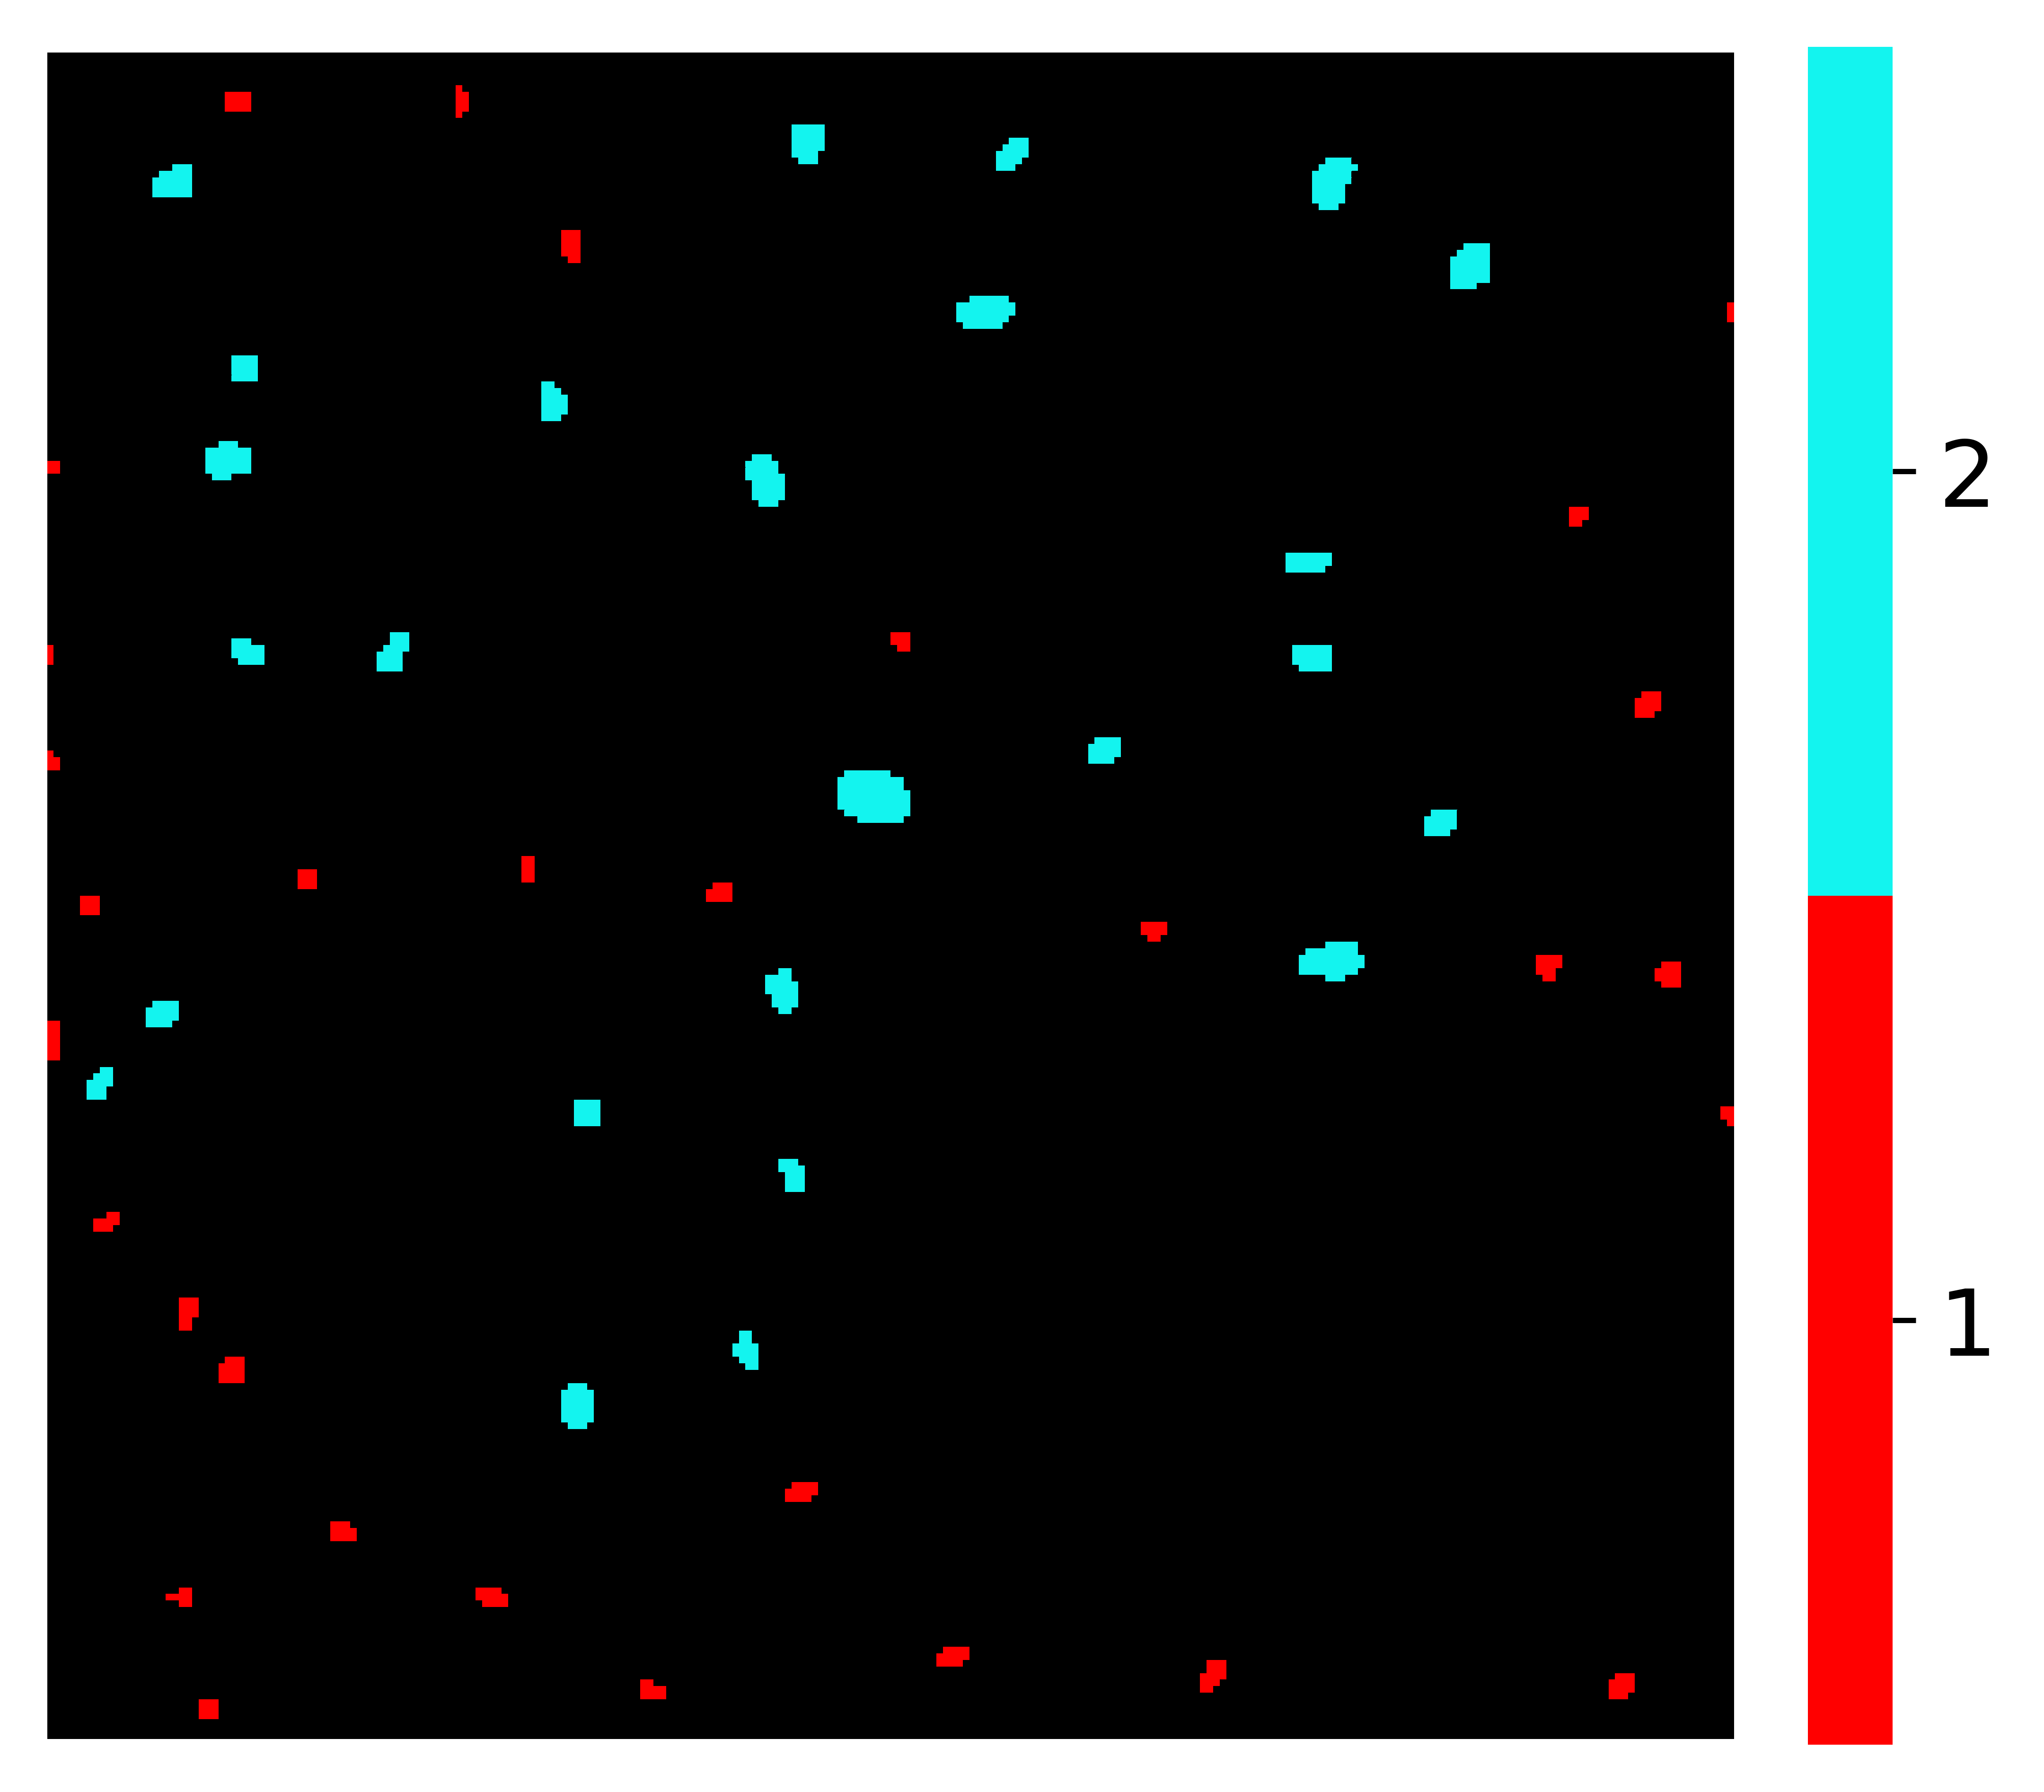

In [470]:
cur_save = 'figures/Supp/{0}/cluster_map.png'.format(tissue_name)
plot_label_image(a.obs[cur_exp_name],a.uns[cur_exp_name+'_colors'],mask=None,save=cur_save)
# mouse0_kidney0_neg0_high0_20_None_auto

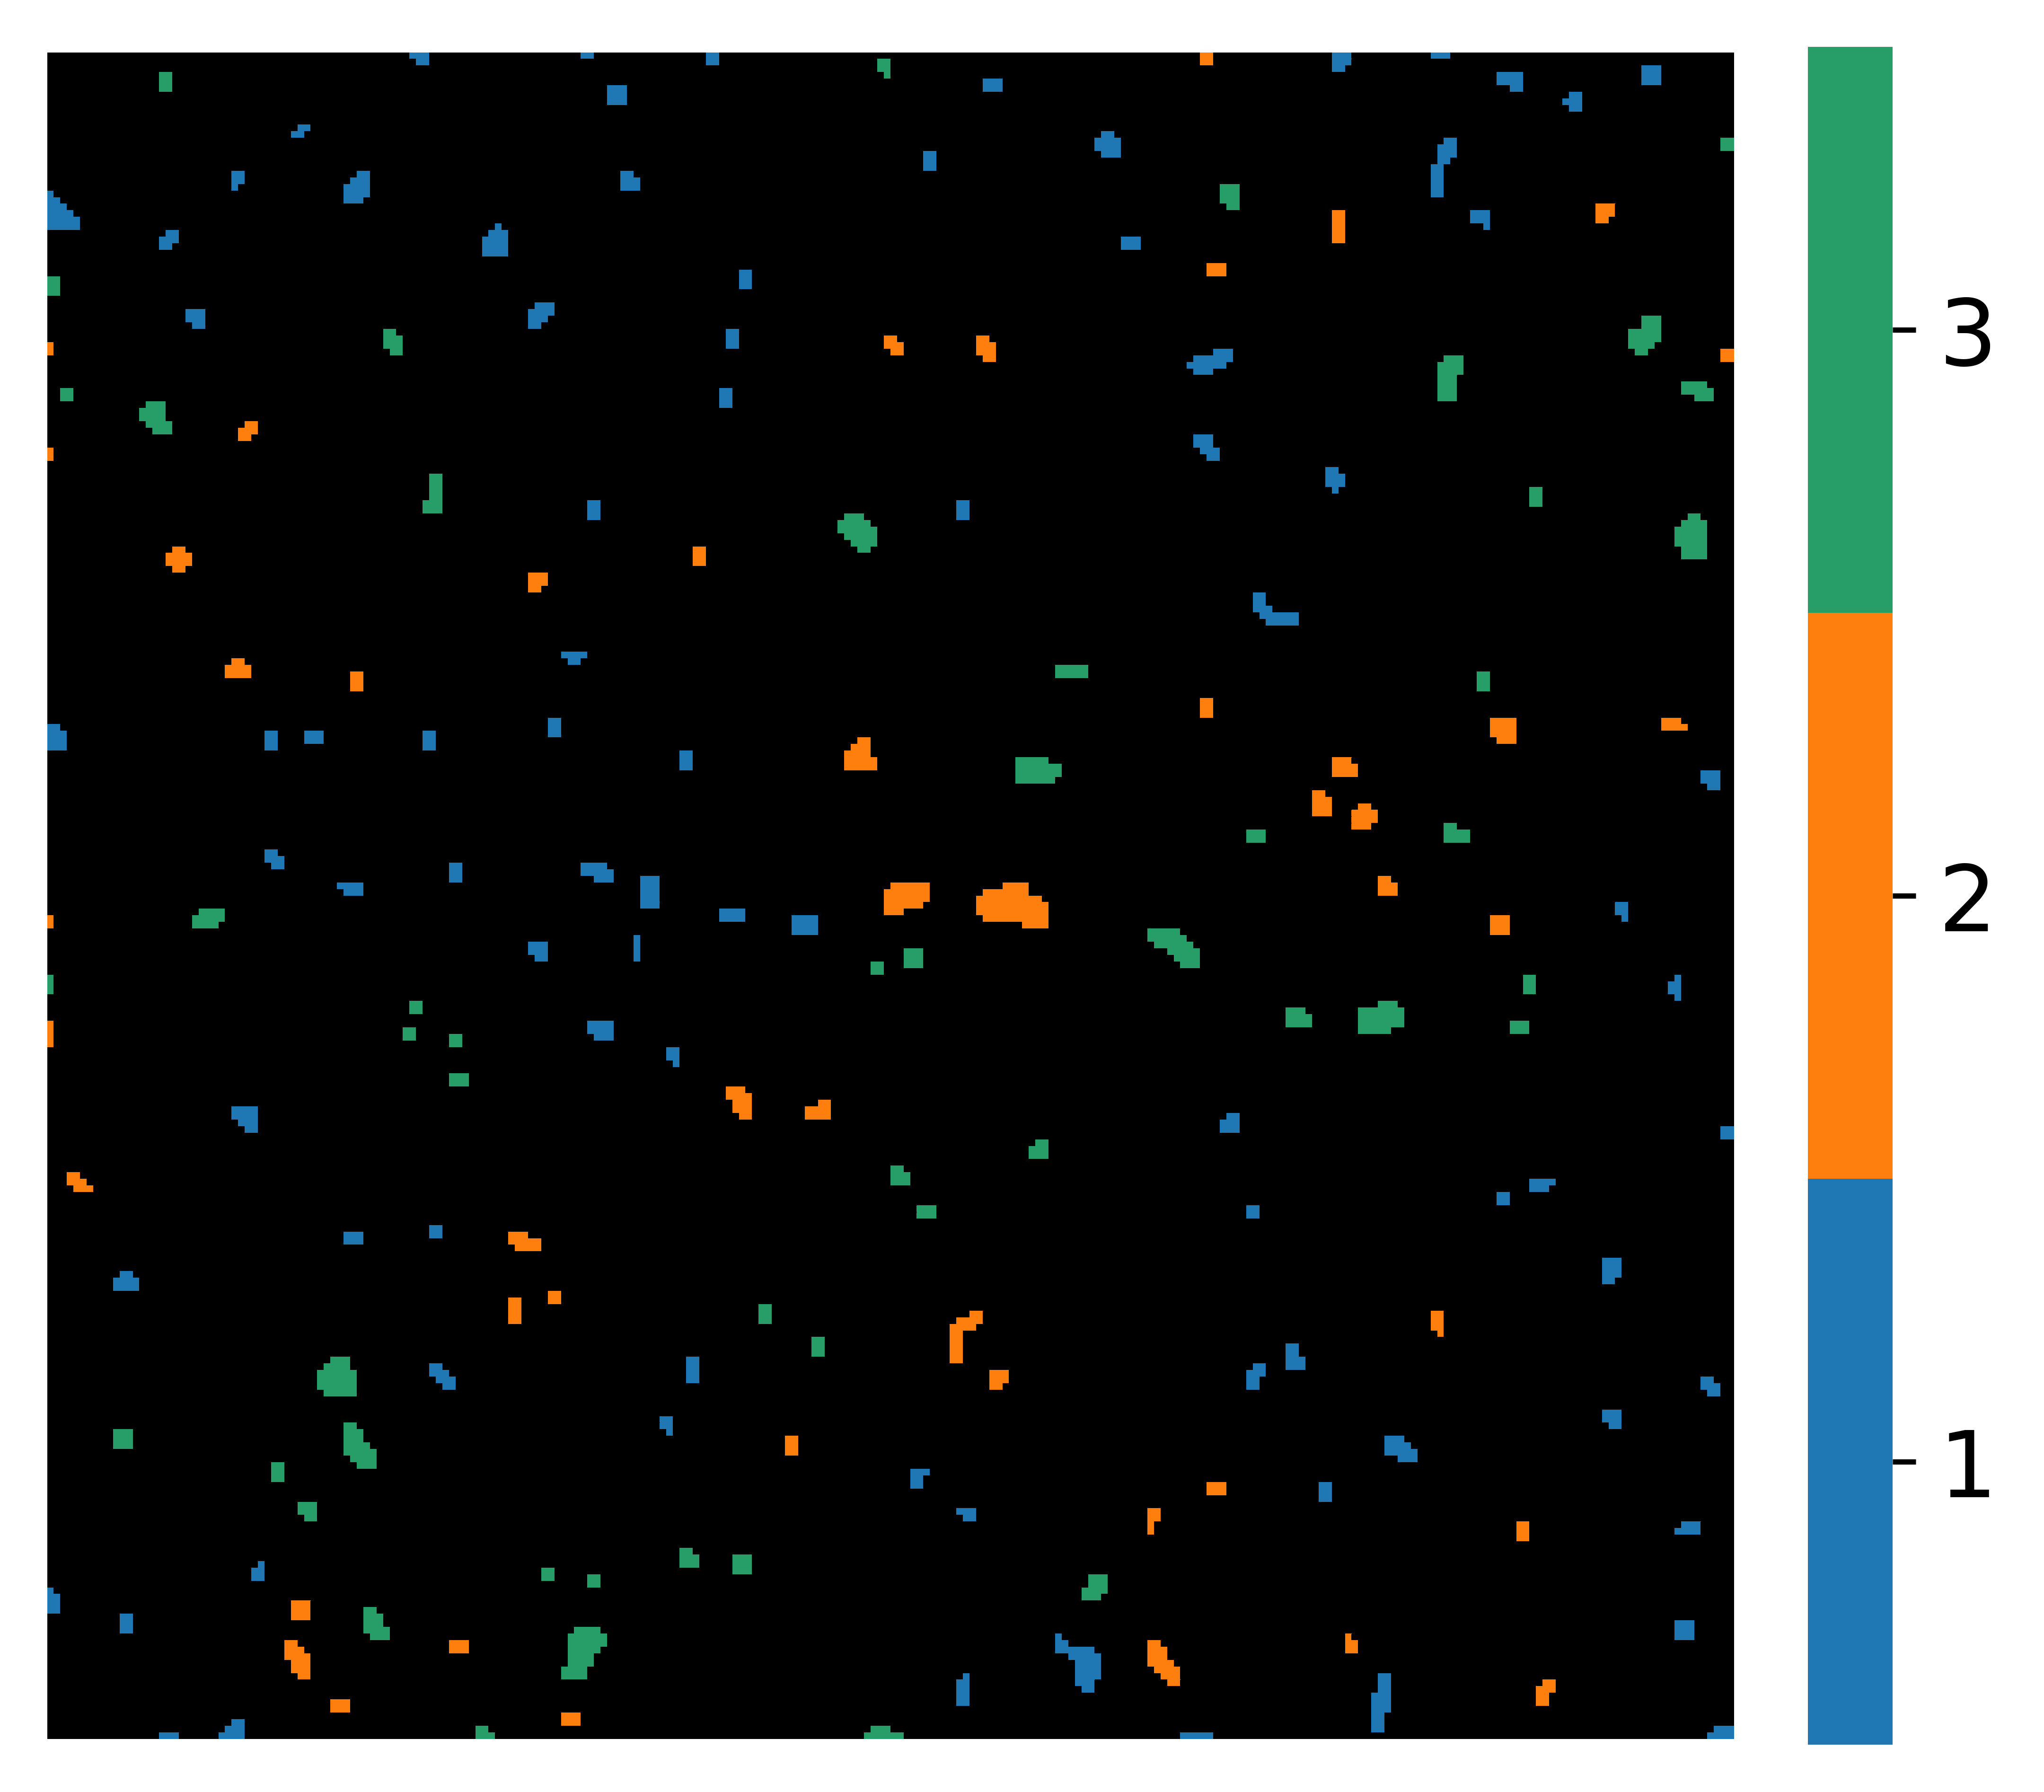

In [378]:
cur_save = 'figures/Supp/{0}/cluster_map.png'.format(tissue_name)
plot_label_image(a.obs[cur_exp_name],a.uns[cur_exp_name+'_colors'],mask=None,save=cur_save)
# mouse0_kidney0_neg0_high0_20_None_auto

In [290]:
tmp_cls = np.arange(num_cells)
tmp_col = ['w']*num_cells

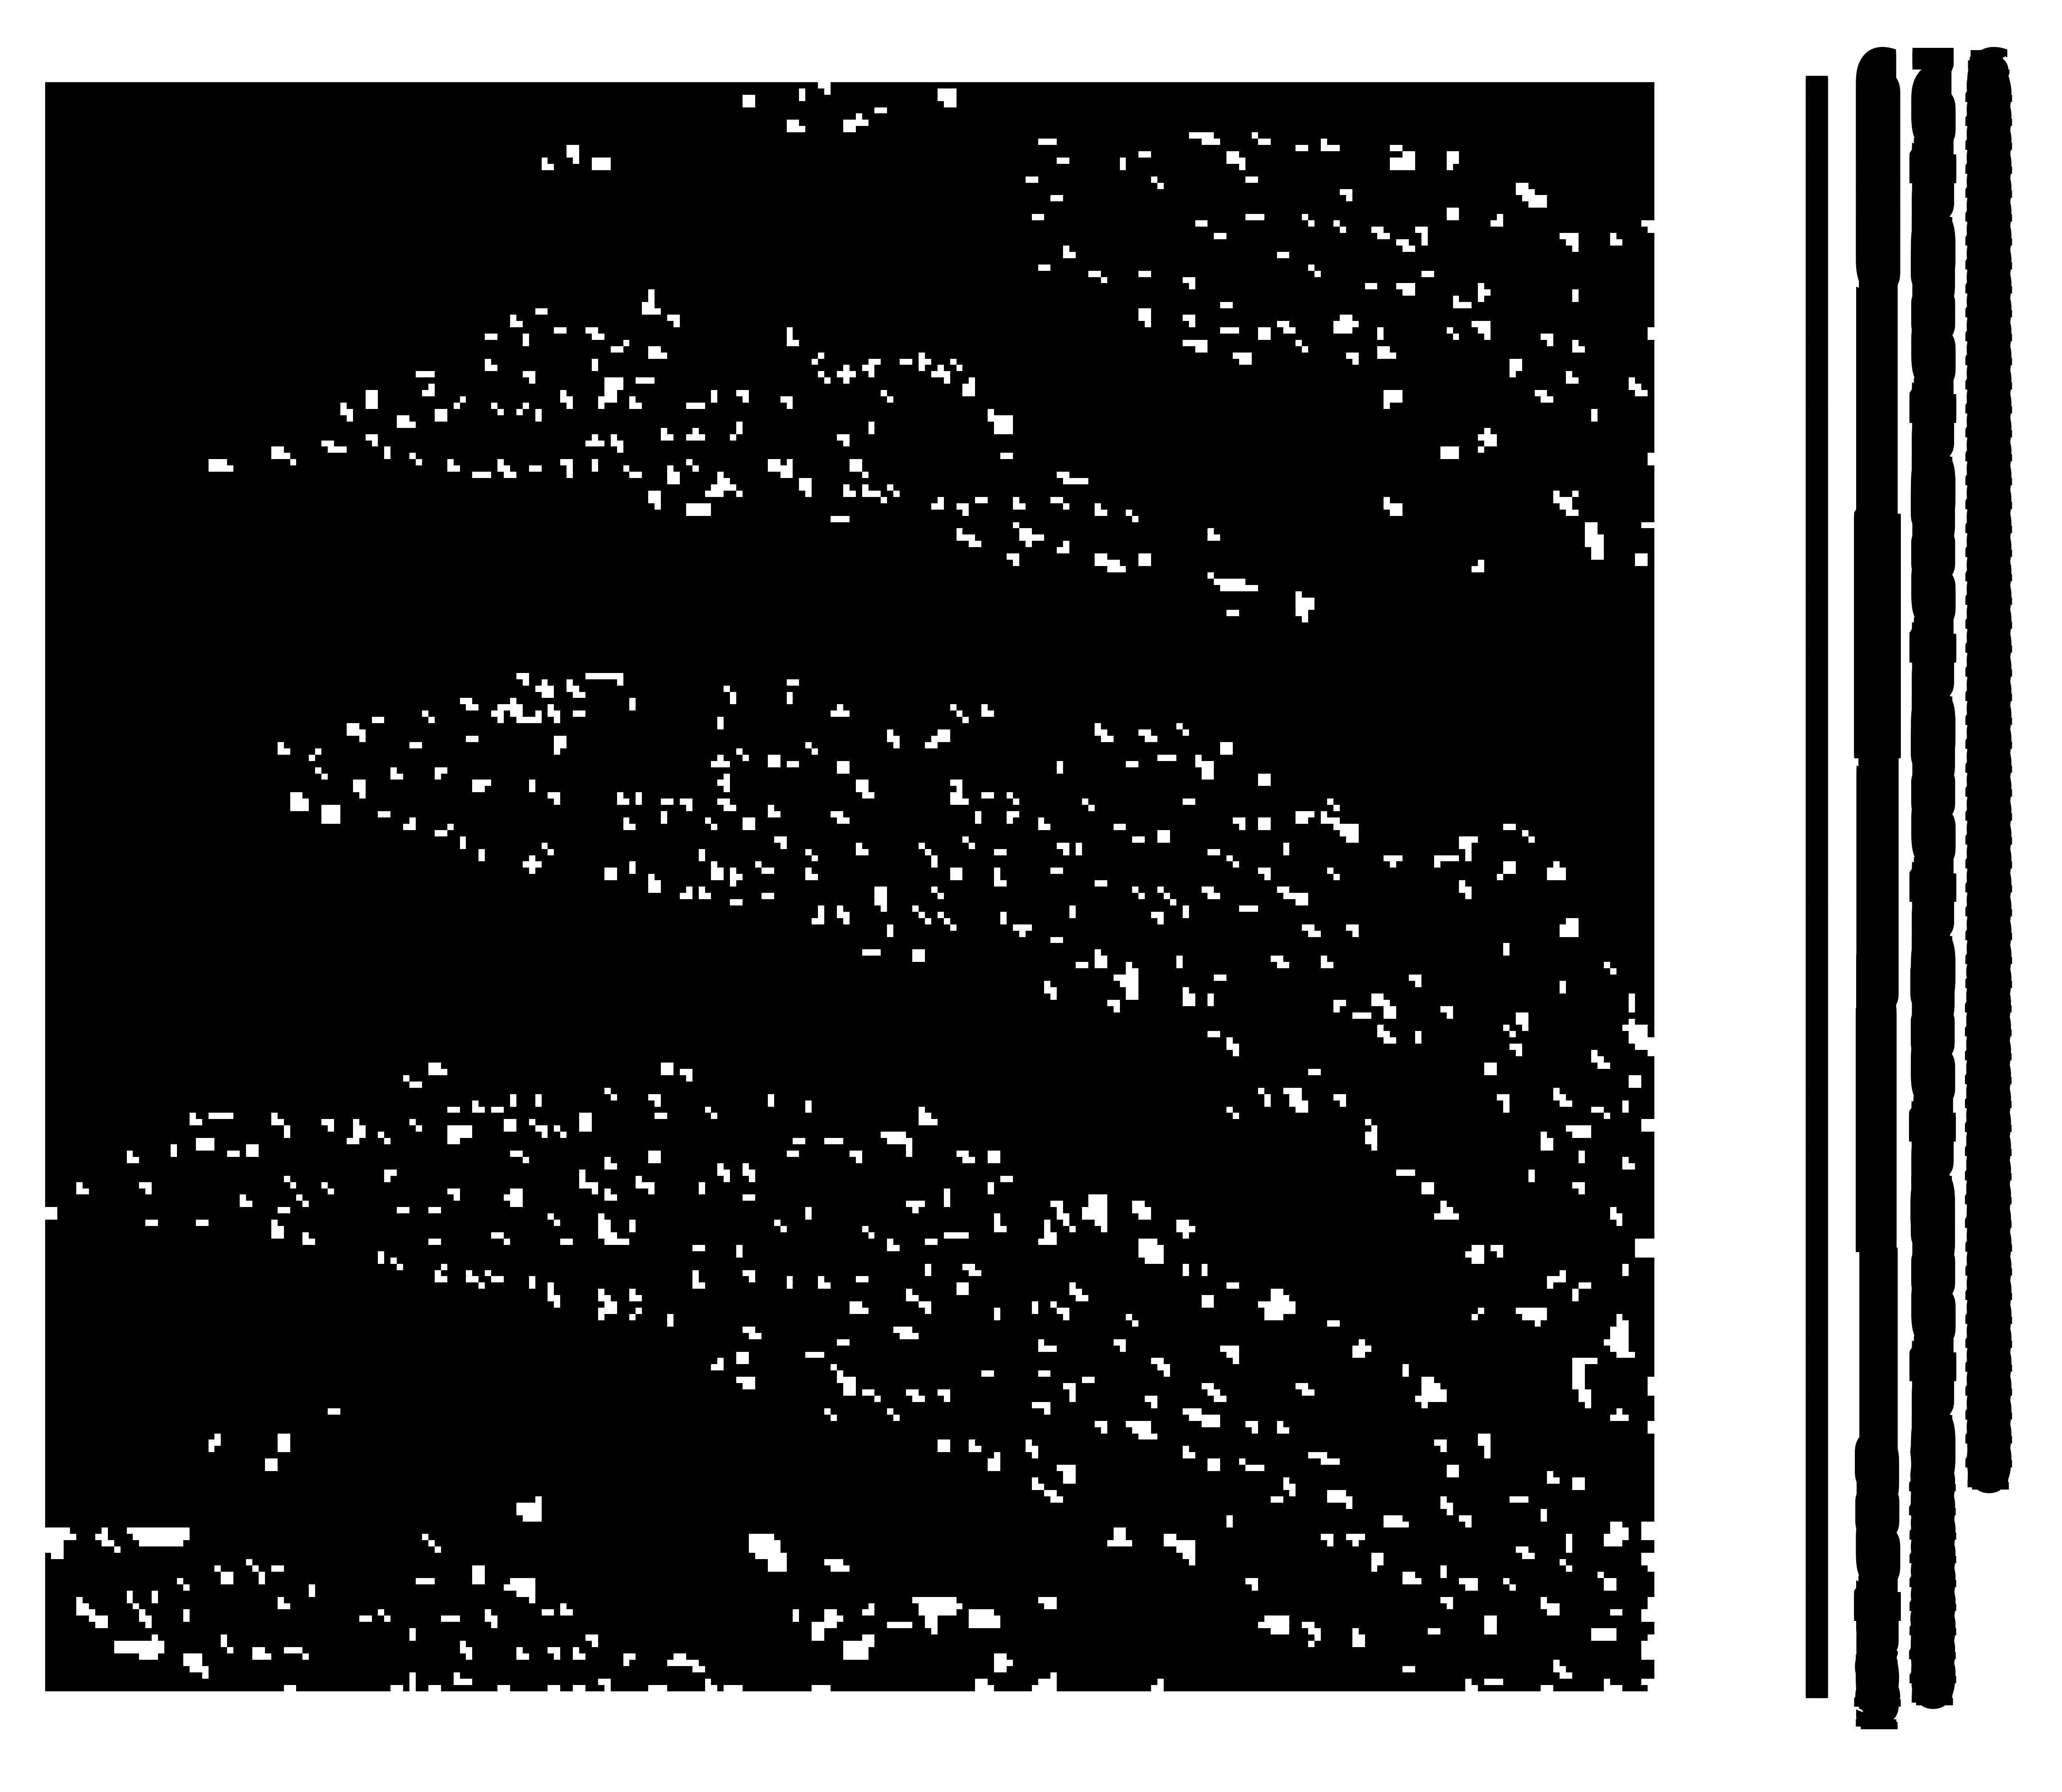

In [291]:
cur_save = 'figures/Supp/{0}/cut.png'.format(tissue_name)

plot_label_image(tmp_cls,tmp_col,mask=None,save=cur_save)


In [385]:
cur_exp_name = 'leiden'

In [463]:
sc.tl.rank_genes_groups(a,groupby=cur_exp_name,method='t-test')

ranking genes
    finished (0:00:00)


In [221]:
import matplotlib
matplotlib.rcParams['font.family'] = 'sans-serif'
# matplotlib.rcParams['font.sans-serif'] = 'Arial'

In [102]:
a

AnnData object with n_obs × n_vars = 540 × 164 
    obs: 'cls_3', 'leiden'
    uns: 'rep_list', 'cls_3_colors', 'neighbors', 'leiden', 'umap', 'rank_genes_groups'
    obsm: 'X_umap', 'cls_3_rep'

In [116]:
gene_list_list = [[]]*5


In [117]:
gene_list_list[0]

[]

In [464]:
n_genes = 10
marker_genes = []
rgg = a.uns['rank_genes_groups']['names']
n_cls = len(rgg[0])
gene_list_list = []
for i in range(n_cls):
    cur_genes = []
    for j in range(n_genes):
        cur_genes.append(rgg[j][i])
    gene_list_list.append(cur_genes)
    marker_genes.extend(cur_genes)


In [465]:
unique_indexes = np.unique(marker_genes, return_index=True)[1]
marker_genes_unique = [marker_genes[index] for index in sorted(unique_indexes)]

In [456]:
a = [65.96]
np.array(a).astype('int')

array([65])

In [466]:
marker_genes = [65.96,81.95,106.99,112.96,128.96,154.94,223.89,244.88,262.88,364.83]
marker_genes = np.array(marker_genes).astype('str')

In [478]:
marker_red = [65.96,81.95,106.99,112.96,128.96]
marker_blue = [154.94,223.89,244.88,262.88,364.83]
marker_red = np.array(marker_red).astype('str')
marker_blue = np.array(marker_blue).astype('str')

In [500]:
red_idx = np.where(a.obs['cls_2']=='0')[0][:26]
blue_idx = np.where(a.obs['cls_2']=='1')[0][:21]

In [504]:
red_idx_list = list(red_idx)
red_idx_list.extend(list(blue_idx))

In [532]:
a_bak_adj = a_bak[red_idx_list]

In [527]:
a_bak = a.copy()

In [531]:
a_bak[red_idx,marker_red].X = a_bak[red_idx,marker_red].X*1.2
a_bak[blue_idx,marker_blue].X = a_bak[blue_idx,marker_blue].X*1.2

In [523]:
marker_genes_cancer = [97,261,80,94,81,213,74,91,75]
marker_genes_cancer = np.array(marker_genes_cancer).astype('str')

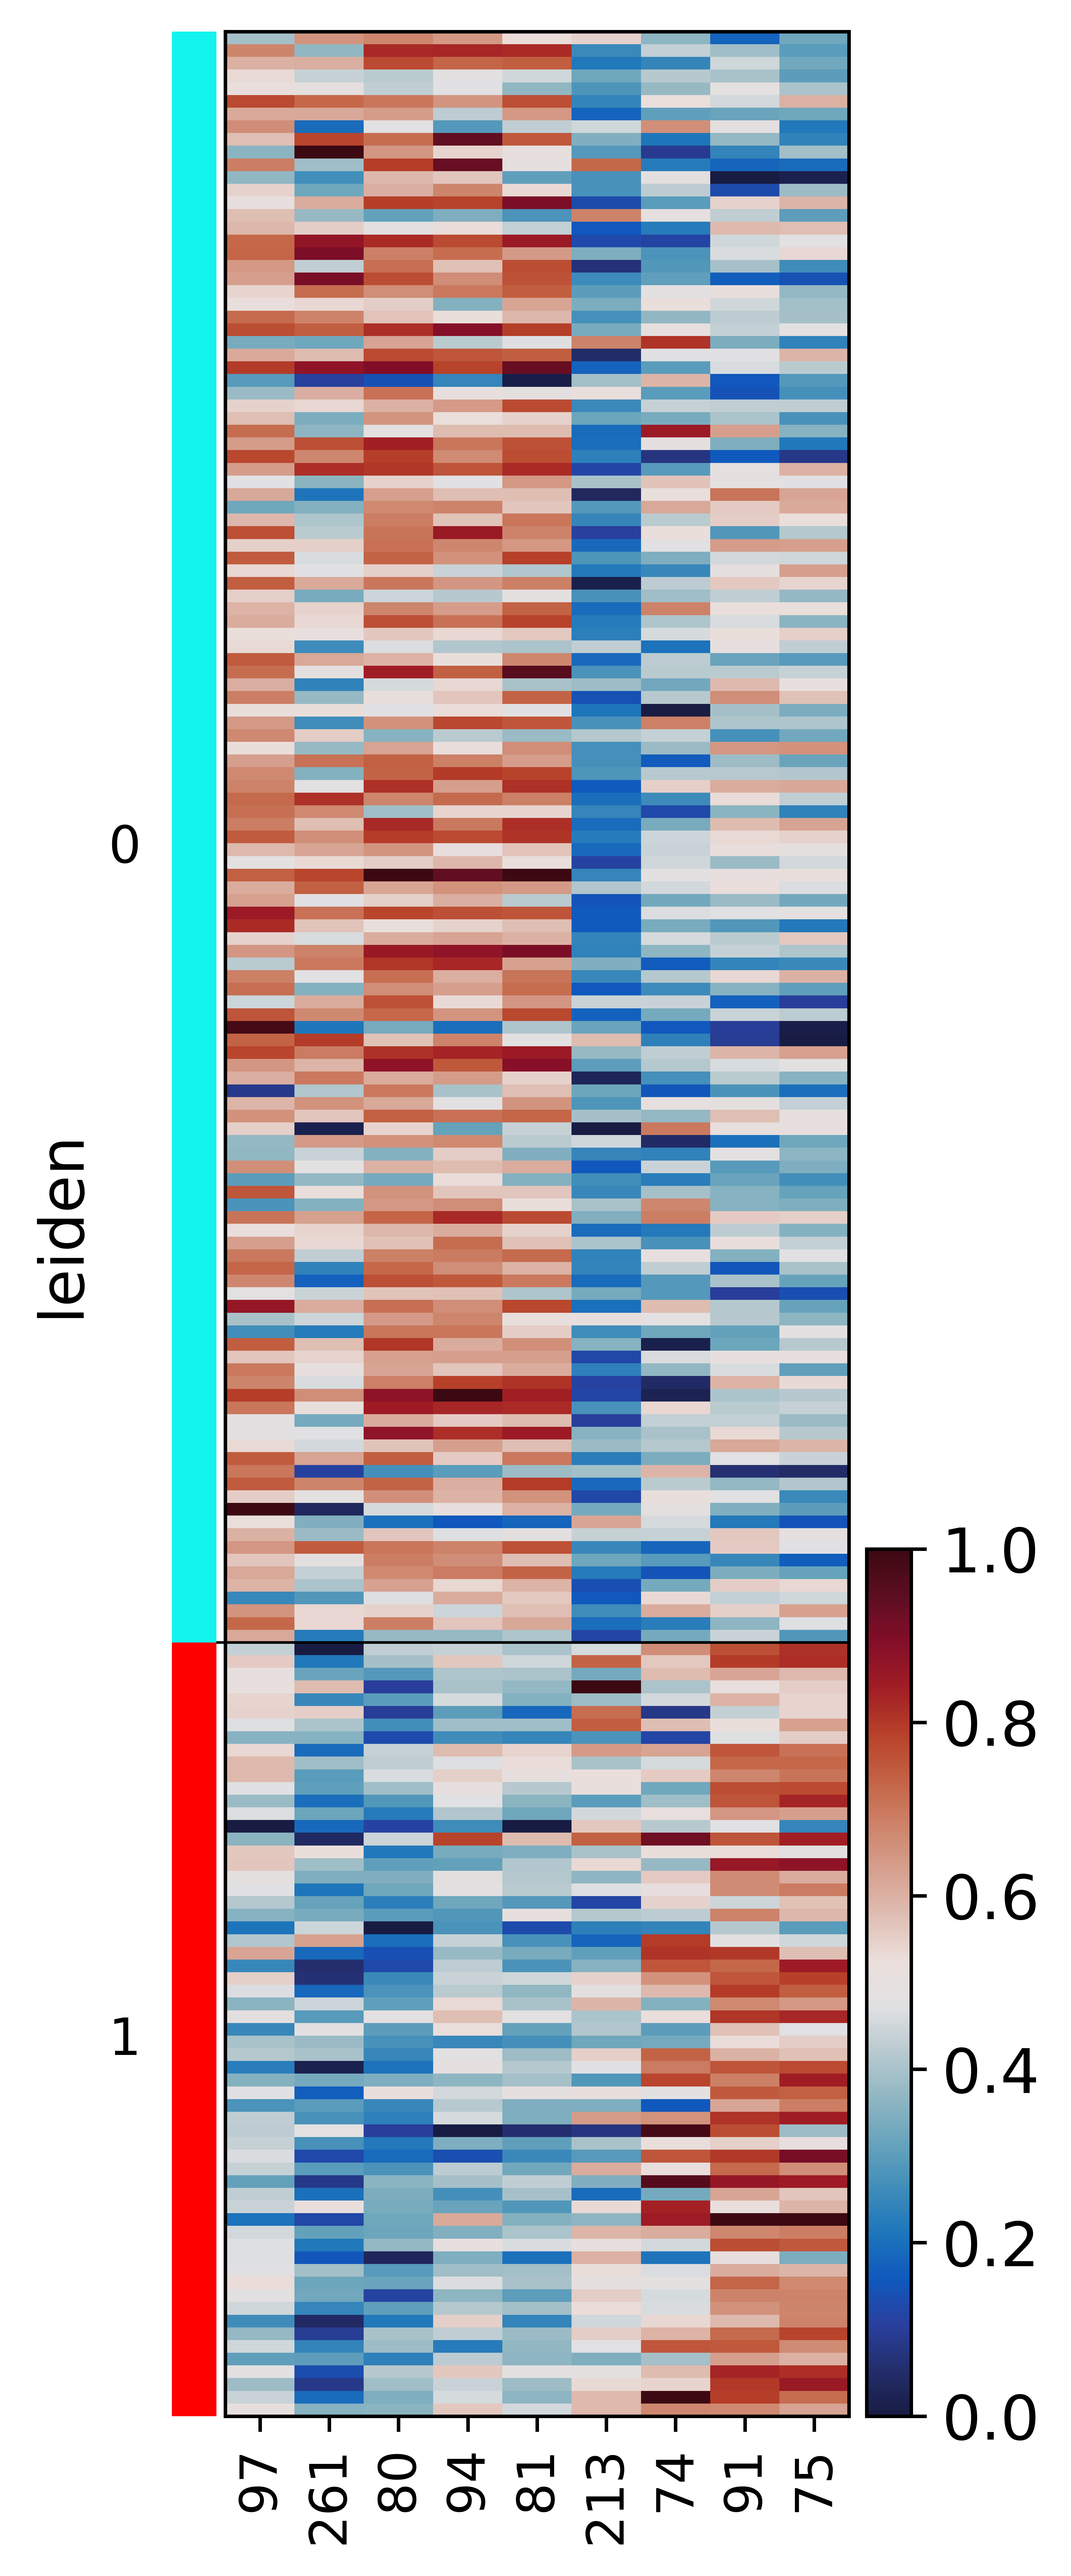

GridSpec(2, 4, height_ratios=[0, 10], width_ratios=[0.2, 2.8, 0, 0.2])

In [525]:

sc.settings.figdir = 'figures/Supp/{0}/'.format(tissue_name)
cur_save = '.png'
sc.pl.heatmap(a_cancer,groupby='leiden',var_names=marker_genes_cancer,standard_scale='var',
                                cmap=heatmap_cmp,dendrogram=False,swap_axes=False,
                                save = cur_save,figsize=(3,10))


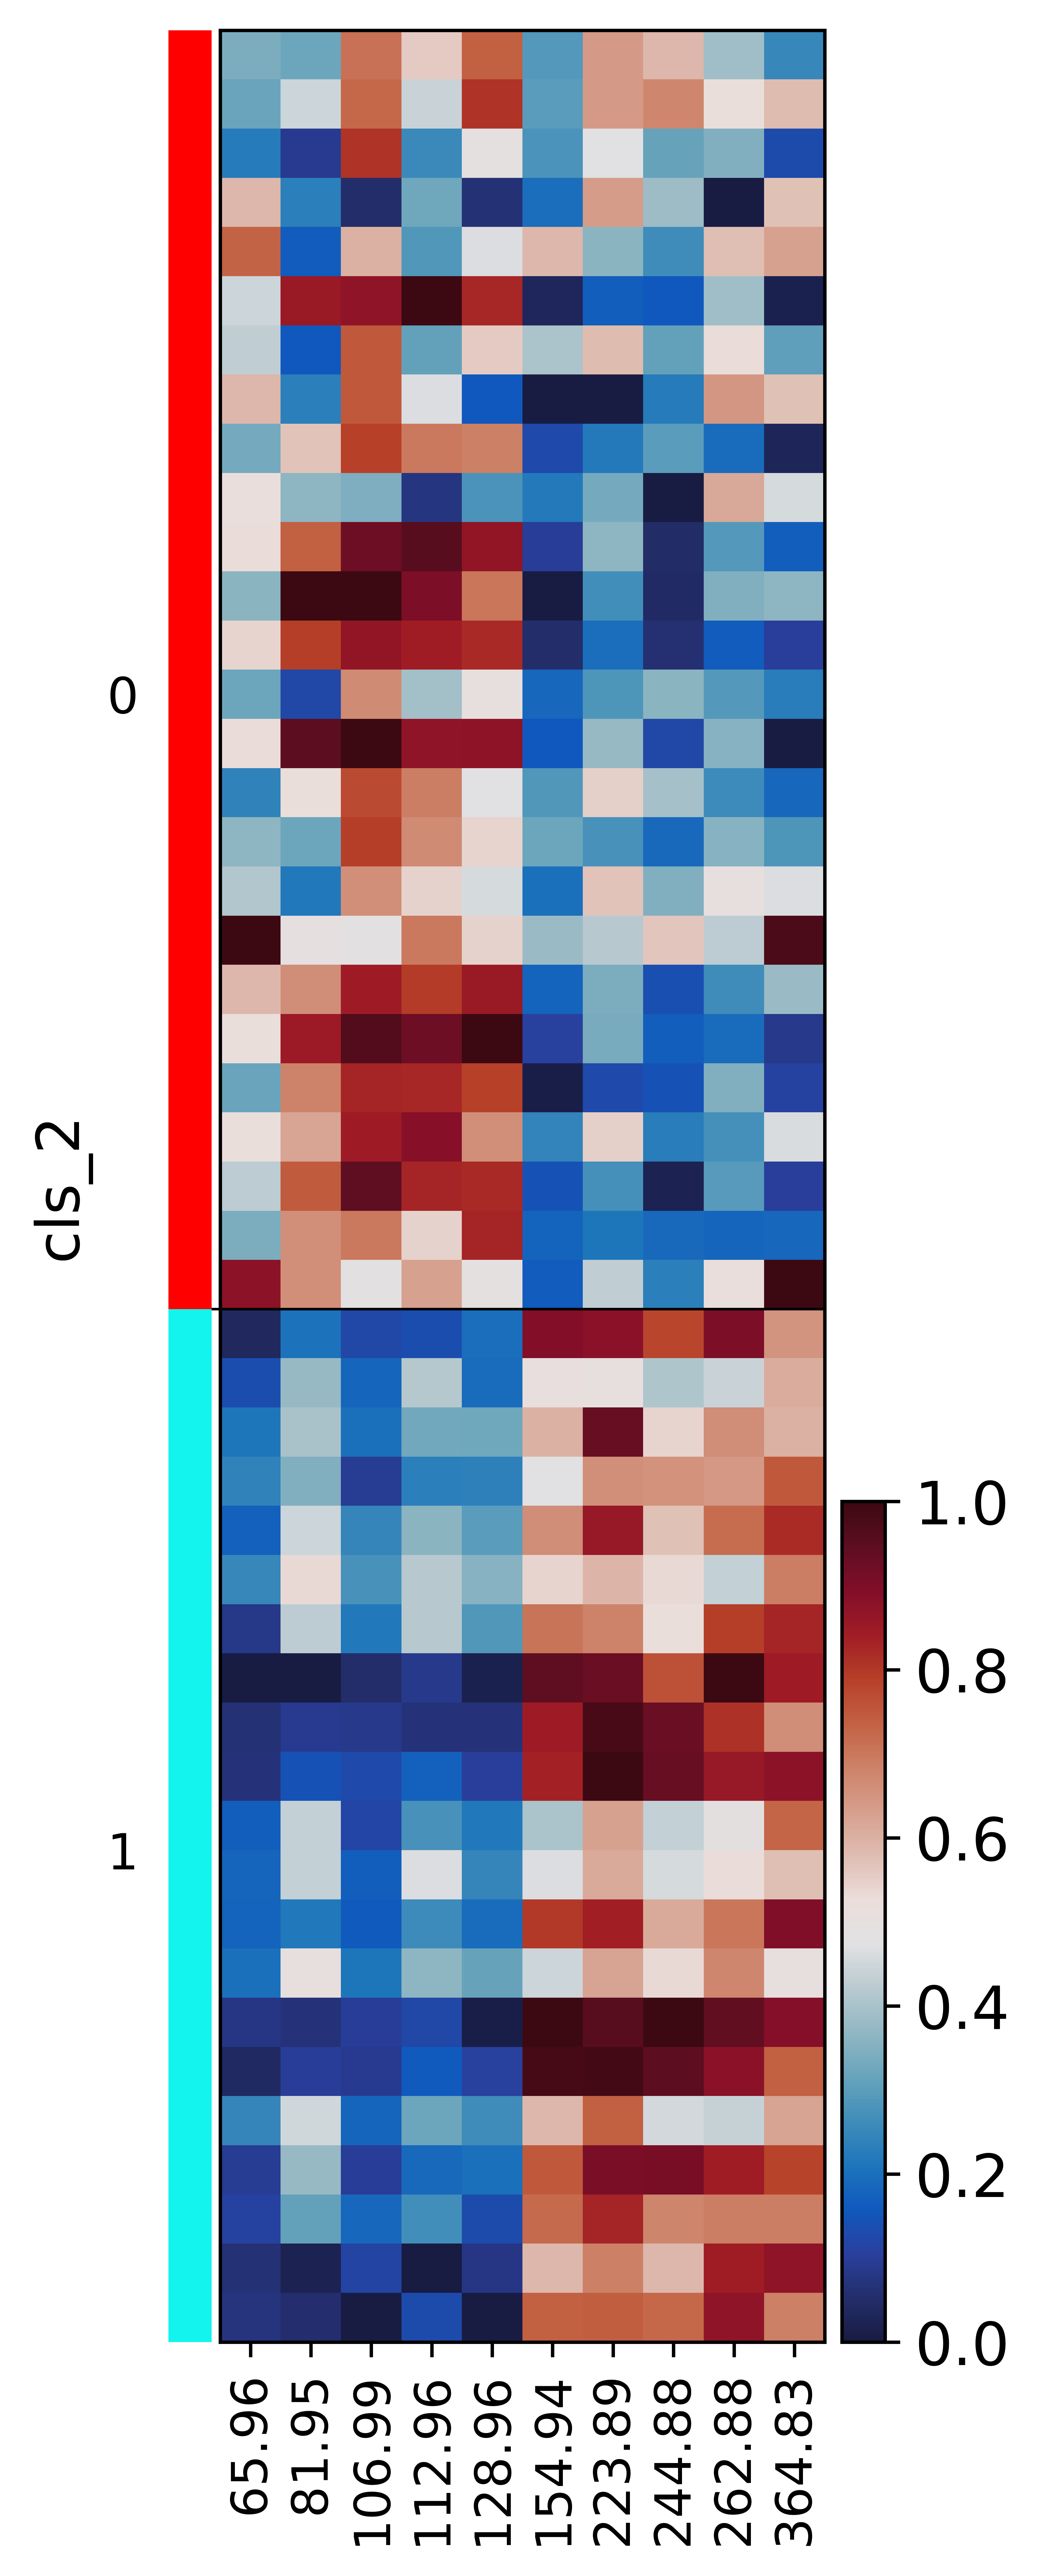

GridSpec(2, 4, height_ratios=[0, 10], width_ratios=[0.2, 2.8, 0, 0.2])

In [533]:

sc.settings.figdir = 'figures/Supp/{0}/'.format(tissue_name)
cur_save = '.png'
sc.pl.heatmap(a_bak_adj,groupby=cur_exp_name,var_names=marker_genes,standard_scale='var',
                                cmap=heatmap_cmp,dendrogram=False,swap_axes=False,
                                save = None,figsize=(3,10))


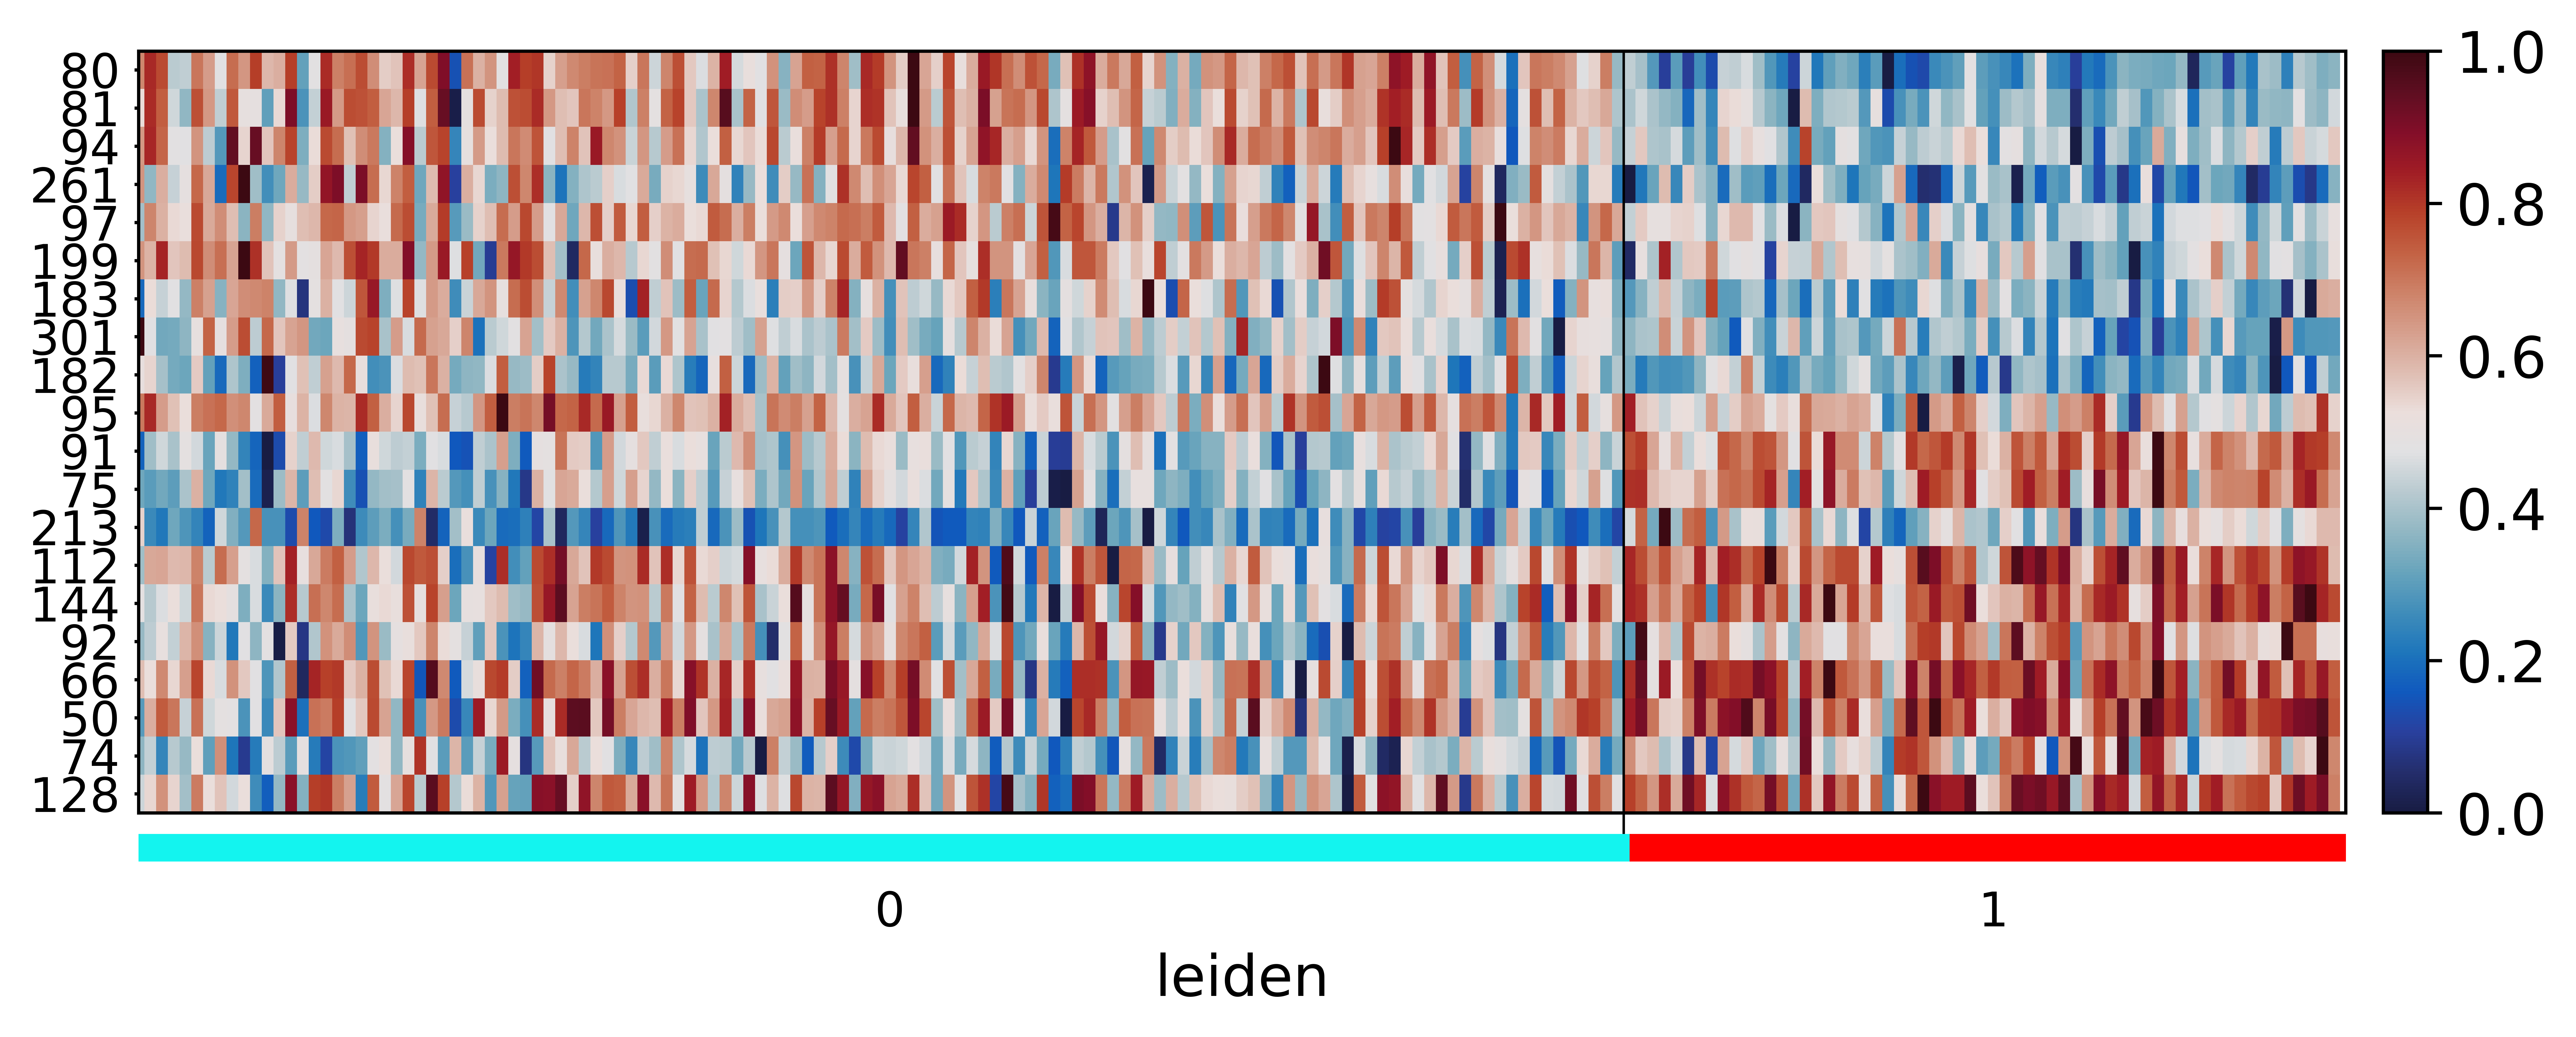

GridSpec(3, 3, height_ratios=[0, 3.5999999999999996, 0.13], width_ratios=[10, 0, 0.2])

In [393]:

sc.settings.figdir = 'figures/Supp/{0}/'.format(tissue_name)
cur_save = '.png'
sc.pl.heatmap(a,groupby=cur_exp_name,var_names=marker_genes_unique,standard_scale='var',
                                cmap=heatmap_cmp,dendrogram=False,swap_axes=True,
                                save = None)


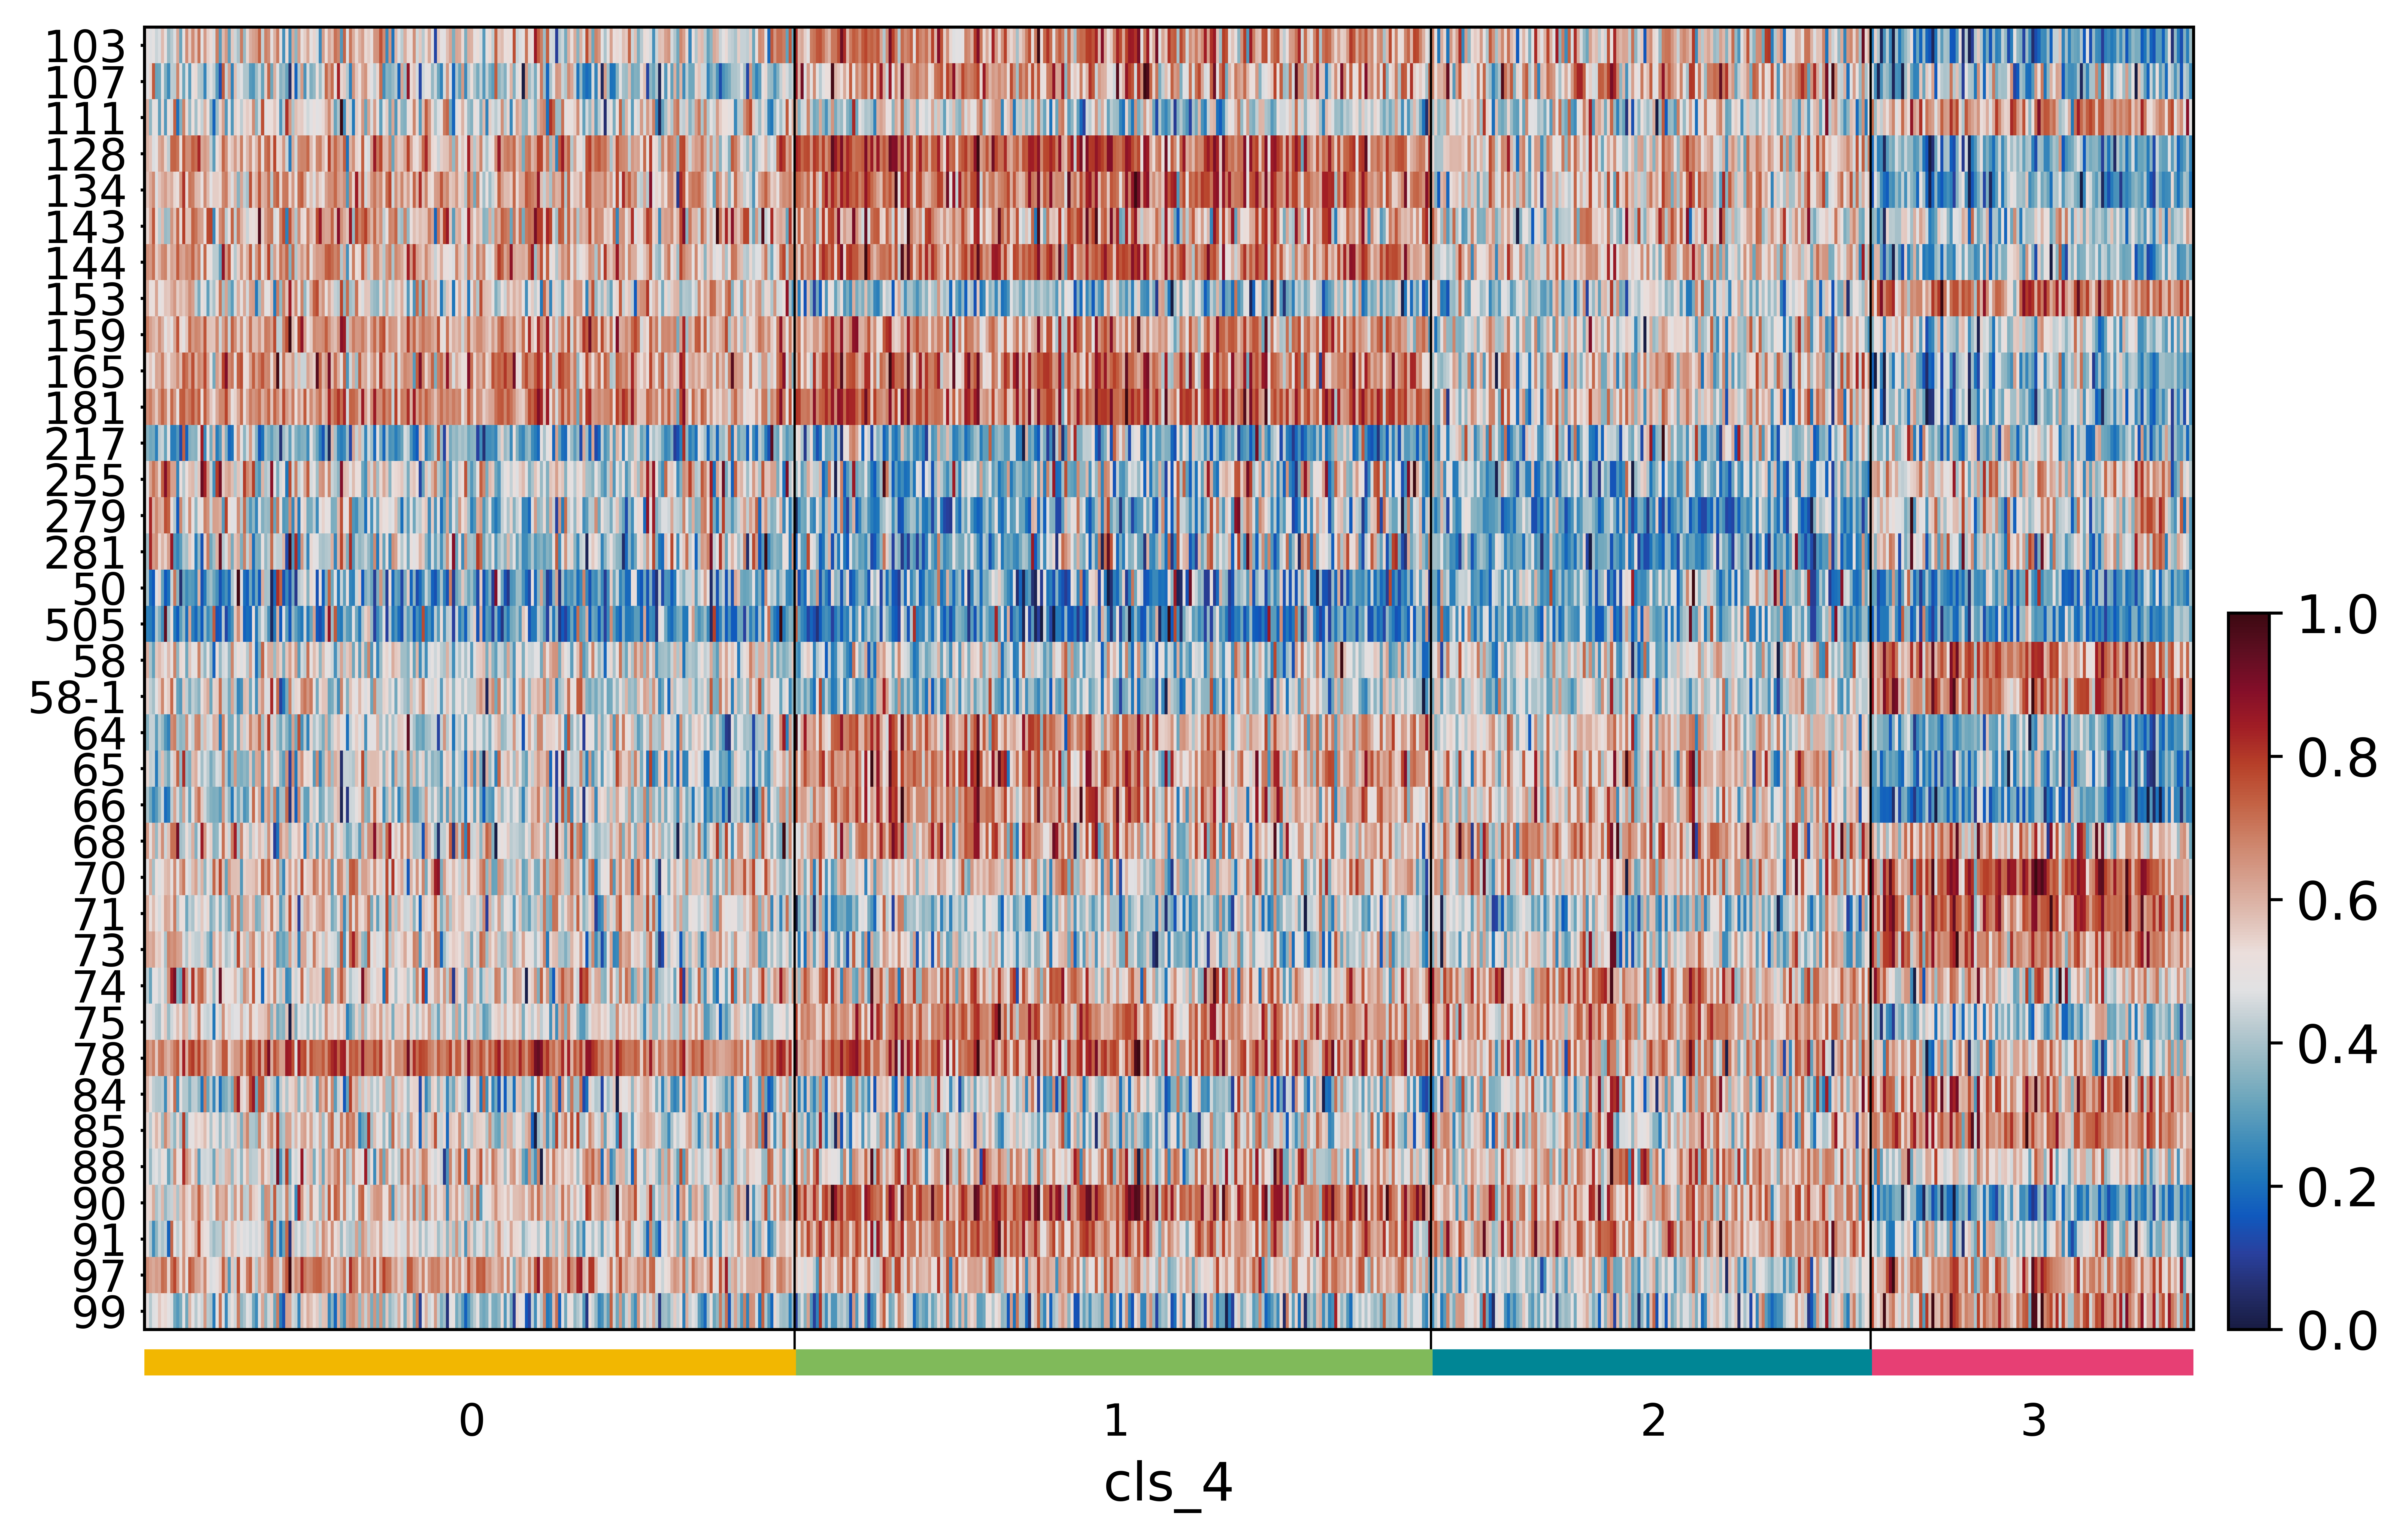

GridSpec(3, 3, height_ratios=[0, 6.4799999999999995, 0.13], width_ratios=[10, 0, 0.2])

In [300]:

sc.settings.figdir = 'figures/Supp/{0}/'.format(tissue_name)
cur_save = '.png'
sc.pl.heatmap(a,groupby=cur_exp_name,var_names=marker_genes_unique,standard_scale='var',
                                cmap=heatmap_cmp,dendrogram=False,swap_axes=True,
                                save = None)


In [331]:
marker_genes_unique

['76',
 '180',
 '75',
 '62',
 '59',
 '77',
 '116',
 '133',
 '102',
 '60-1',
 '152',
 '70',
 '58',
 '136',
 '72',
 '98',
 '83',
 '122',
 '69',
 '254',
 '78',
 '127',
 '96',
 '158',
 '64',
 '143',
 '89',
 '65',
 '90',
 '74',
 '99',
 '57',
 '86',
 '68',
 '106',
 '67']

In [332]:
to_remove = '60-1'
marker_genes_unique = np.array(marker_genes_unique).astype('str')
np.where(marker_genes_unique==to_remove)

(array([9]),)

In [333]:
marker_genes_unique_removed = np.delete(marker_genes_unique,[9])

In [321]:
marker_genes_unique_removed

array(['78', '159', '97', '181', '255', '165', '279', '143', '153', '281',
       '128', '90', '134', '66', '144', '75', '64', '103', '65', '91',
       '107', '74', '50', '88', '505', '217', '68', '71', '58', '73',
       '85', '99', '70', '84', '111'], dtype='<U4')

In [334]:
tissue_name

'kidney'

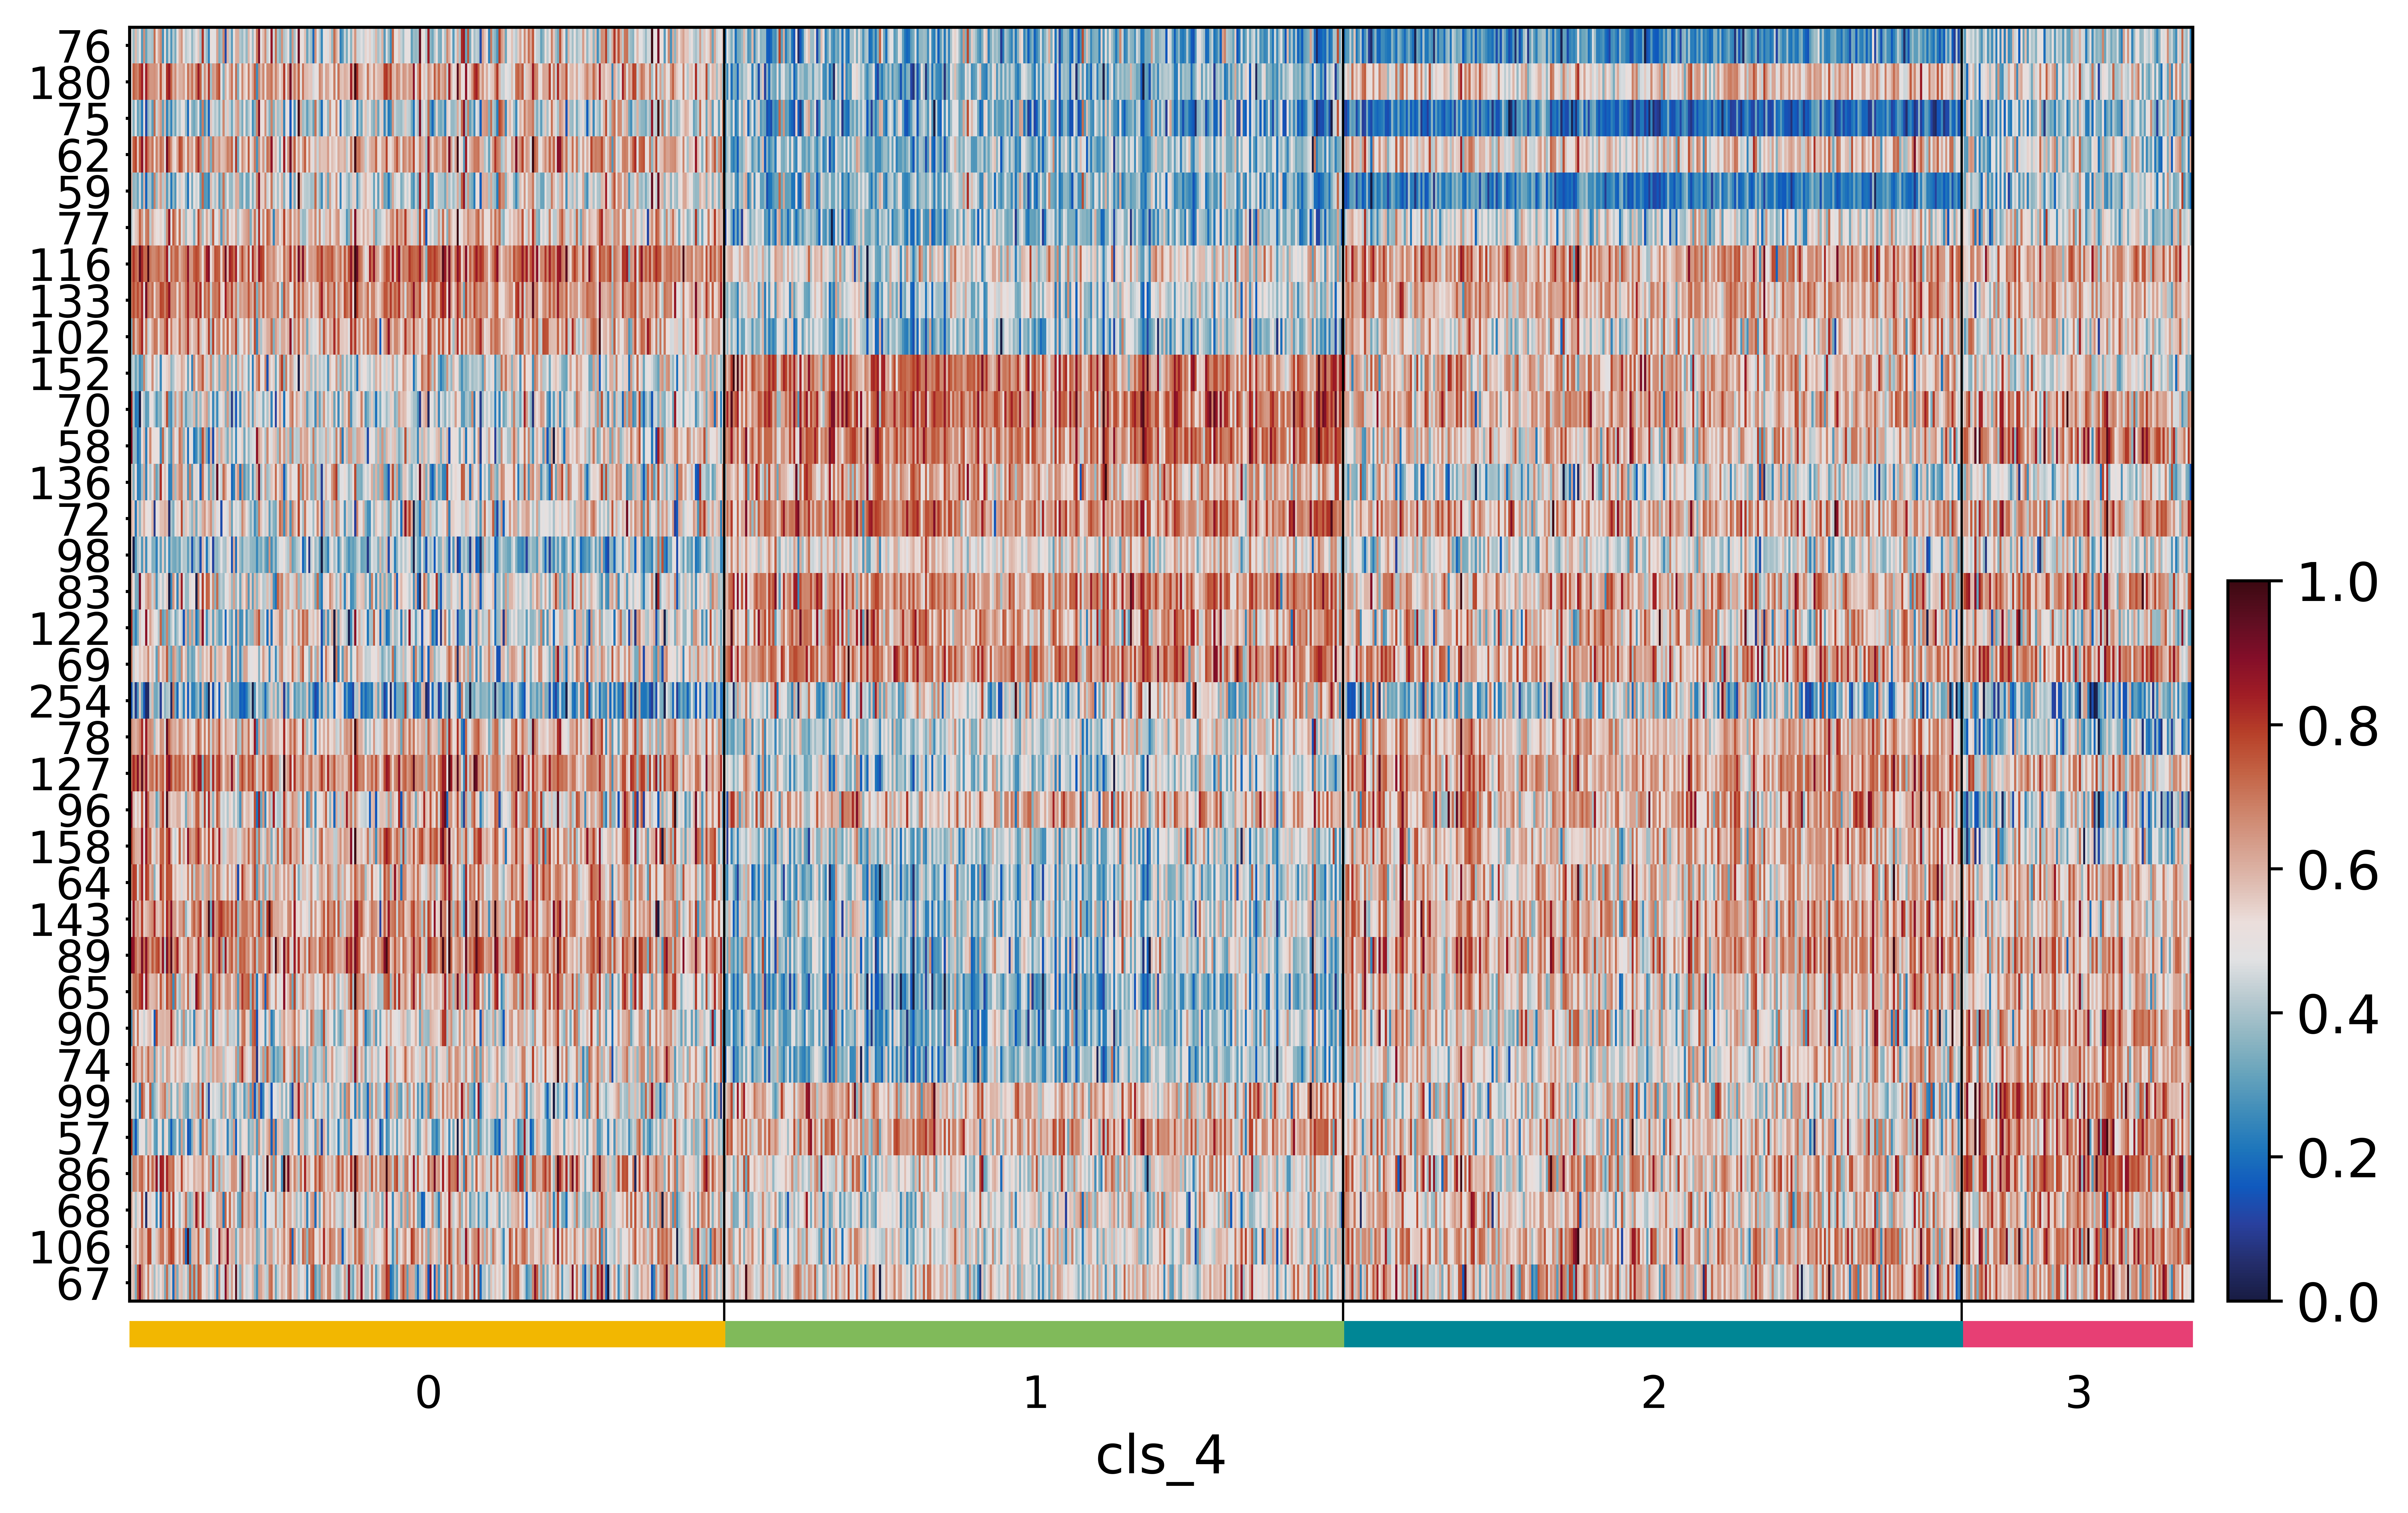

GridSpec(3, 3, height_ratios=[0, 6.3, 0.13], width_ratios=[10, 0, 0.2])

In [335]:

sc.settings.figdir = 'figures/Supp/{0}/'.format(tissue_name)
cur_save = '.png'
sc.pl.heatmap(a,groupby=cur_exp_name,var_names=marker_genes_unique_removed,standard_scale='var',
                                cmap=heatmap_cmp,dendrogram=False,swap_axes=True,
                                save = cur_save)


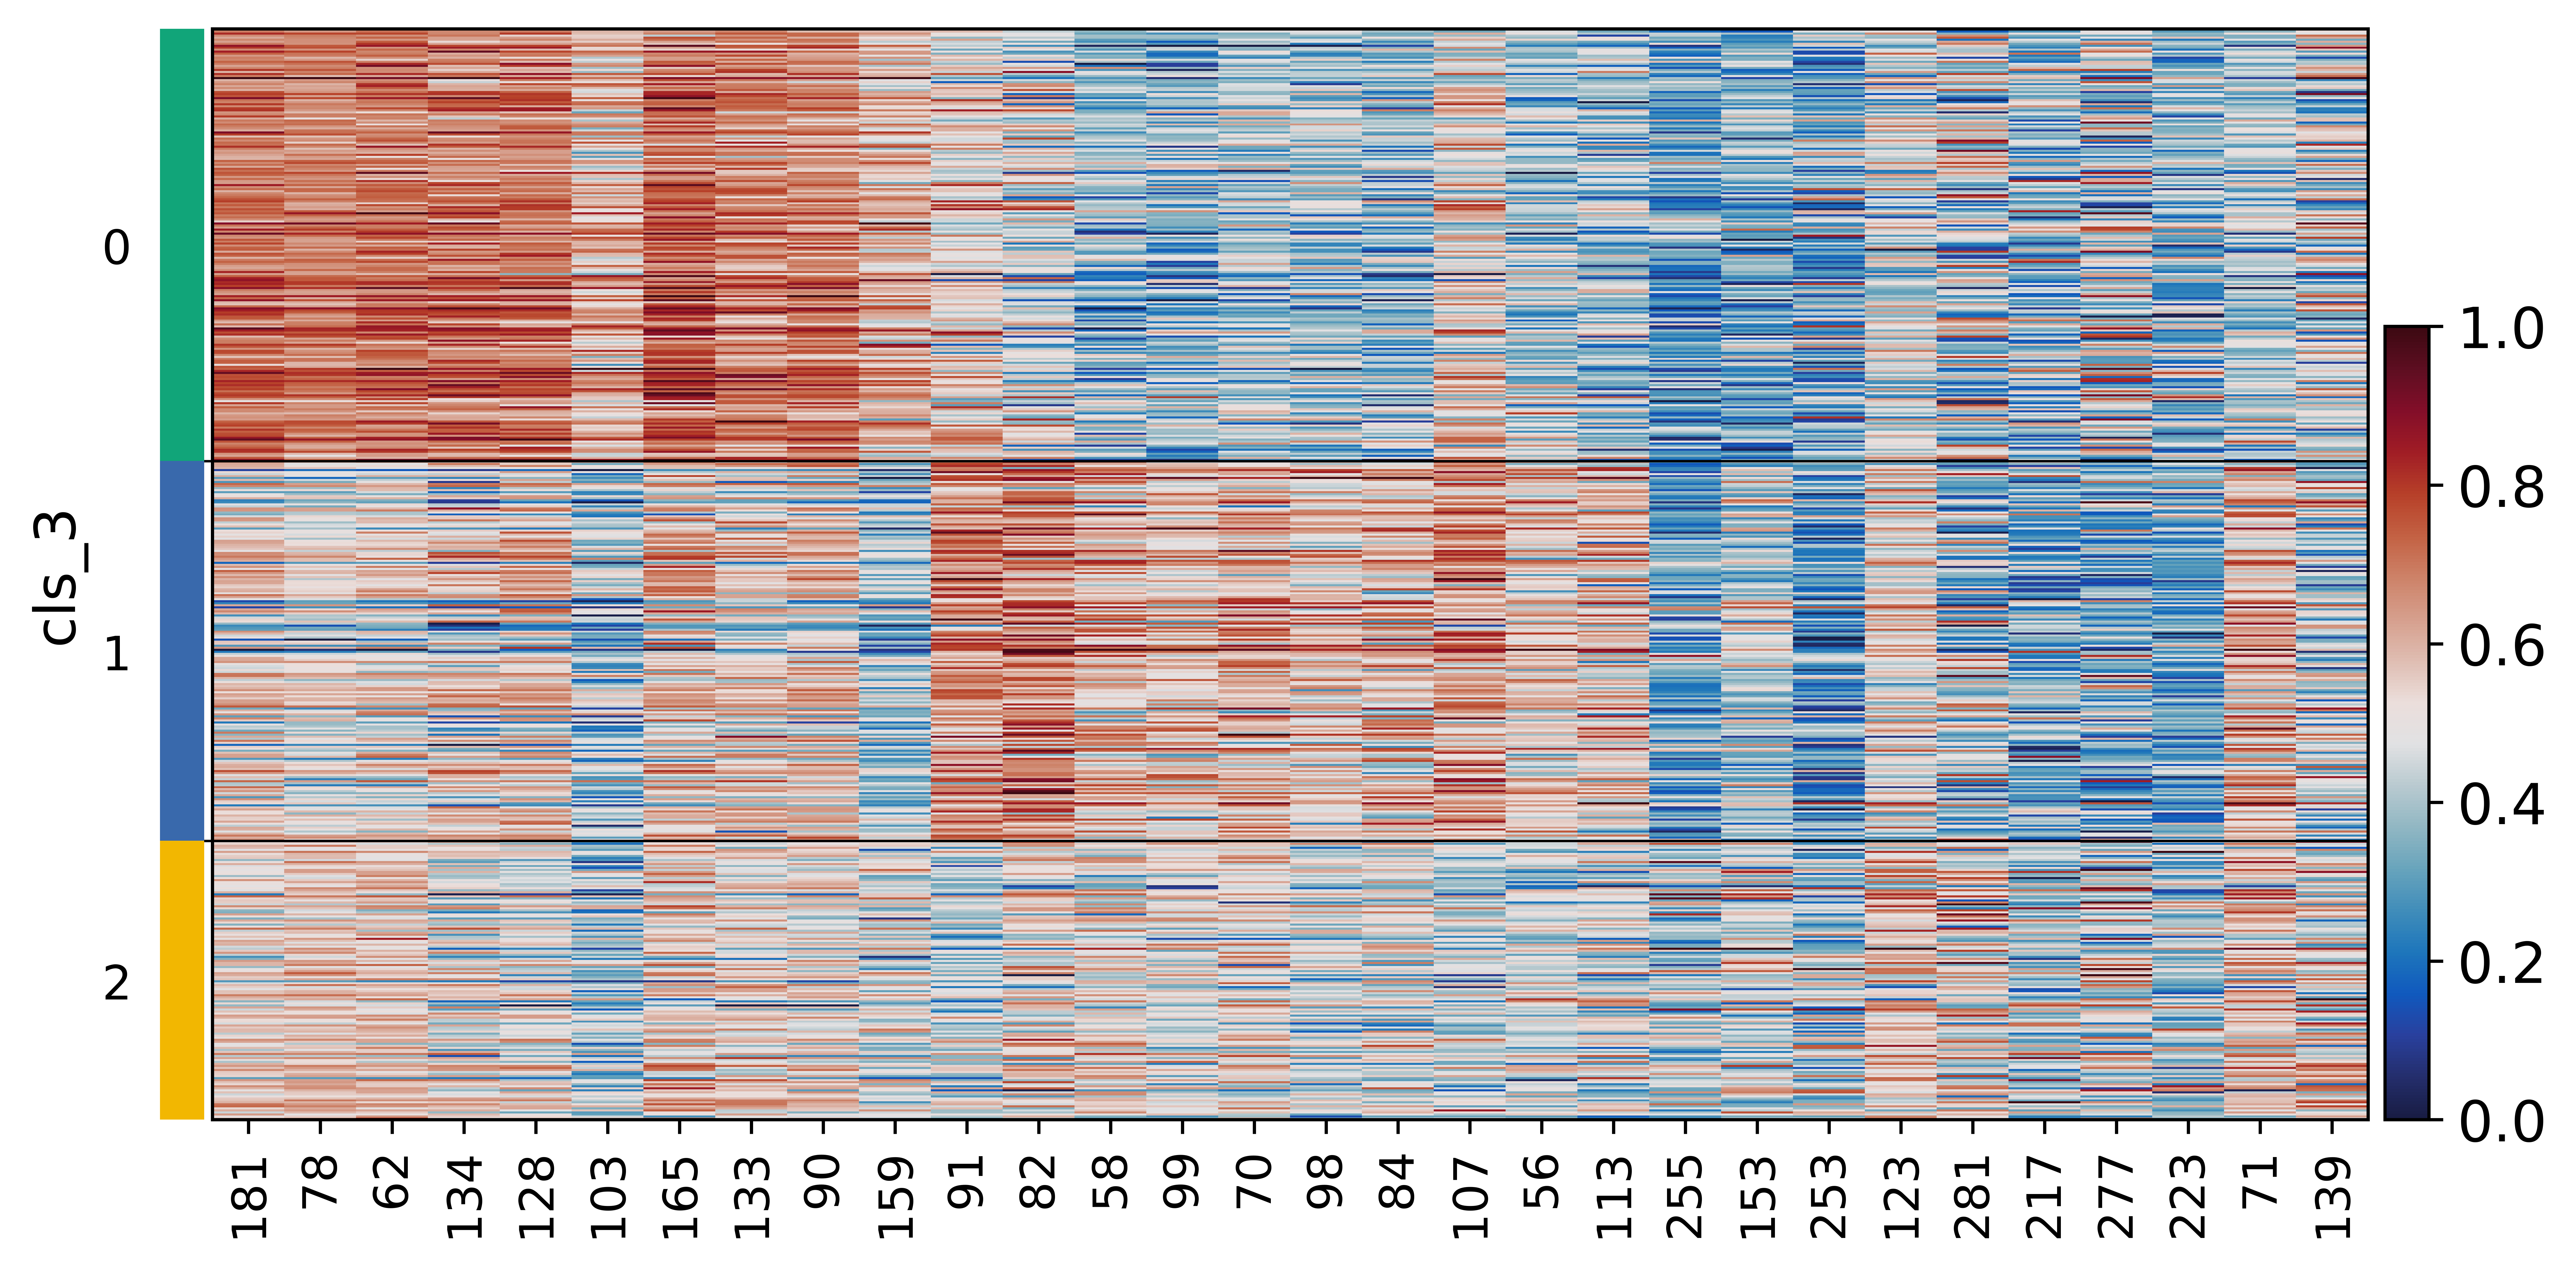

GridSpec(2, 4, height_ratios=[0, 5], width_ratios=[0.2, 9.8, 0, 0.2])

In [146]:
sc.pl.heatmap(a,groupby=cur_exp_name,var_names=marker_genes,standard_scale='var',
                                cmap=heatmap_cmp,dendrogram=False,swap_axes=False,
                                save = None,figsize=(10,5))

# save anndata

In [511]:
a_bak_adj.write('figures/Supp/{0}/data.h5py'.format(tissue_name))

In [399]:
a.write('figures/Supp/{0}/data.h5py'.format(tissue_name))

In [225]:
a.write('figures/Fig4_dump_data/fig4_csub.h5ad')

In [166]:
a.write('figures/Fig4_dump_data/fig4_rep0_cls6_reorder_full_side2.h5ad')

In [226]:
a_test = ad.read_h5ad('/home/yzy/ipynbs/figures/Fig4_dump_data/fig4_csub.h5ad')


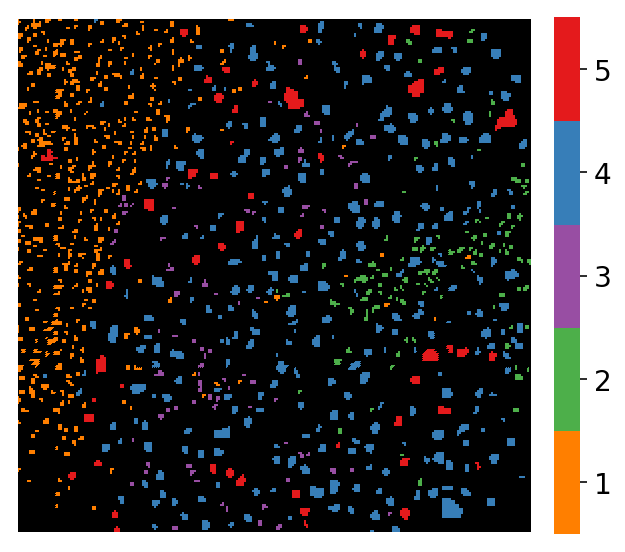

In [227]:
plot_label_image(a_test.obs['cls_sub'],a_test.uns['cls_sub_colors'],mask=[0,1,2,3,4])


# test sam

In [2]:
rep0_dump = 'fig4_rep0_cls6_reorder_full.h5ad'
rep1_dump = 'fig4_rep1_cls6_full_adddist.h5ad'
rep2_dump = 'fig4_rep2_cls6_reorder_full.h5ad'
rep3_dump = 'fig4_rep3_cls6_reorder_full.h5ad'

rep0_dump_side2 = 'fig4_rep0_cls6_reorder_full_side2.h5ad'
rep2_dump_side2 = 'fig4_rep2_cls6_reorder_full_side2.h5ad'

a_rep0 = ad.read_h5ad('/home/yzy/ipynbs/figures/Fig4_dump_data/'+rep0_dump)
# a_rep1 = ad.read_h5ad('/home/yzy/ipynbs/figures/Fig4_dump_data/'+rep1_dump)
# a_rep2 = ad.read_h5ad('/home/yzy/ipynbs/figures/Fig4_dump_data/'+rep2_dump)
# a_rep3 = ad.read_h5ad('/home/yzy/ipynbs/figures/Fig4_dump_data/'+rep3_dump)
# a_rep0_side2 = ad.read_h5ad('/home/yzy/ipynbs/figures/Fig4_dump_data/'+rep0_dump_side2)[:,0]
# a_rep2_side2 = ad.read_h5ad('/home/yzy/ipynbs/figures/Fig4_dump_data/'+rep2_dump_side2)[:,0]

# a_rep0 = a_rep0[:,0]

 

In [3]:
sc.external.tl.sam(a_rep0,inplace=True)

Self-assembling manifold
Running SAM
RUNNING SAM
Iteration: 0, Convergence: 0.3194859870805147
Iteration: 1, Convergence: 0.19568832966562577
Iteration: 2, Convergence: 0.01552425814299475
Computing the UMAP embedding...
Elapsed time: 4.636715412139893 seconds


In [6]:
a_rep0

AnnData object with n_obs × n_vars = 716 × 231 
    obs: 'cls_5', 'cls_5_pca', 'cls_8_pca', 'cls_4', 'leiden', 'cls_5_reorder', 'fibro_dist', 'fibro_dist_mum'
    var: 'spatial_dispersions', 'weights'
    uns: 'cls_4_colors', 'cls_5_colors', 'cls_5_pca_colors', 'cls_5_reorder_colors', 'cls_8_pca_colors', 'leiden', 'leiden_colors', 'neighbors', 'rep_list', 'umap', 'sam'
    obsm: 'X_umap', 'cls_4_rep', 'cls_5_pca_rep', 'cls_5_rep', 'cls_8_pca_rep', 'spatial', 'X_pca'
    varm: 'PCs'
    layers: 'X_disp', 'X_knn_avg'

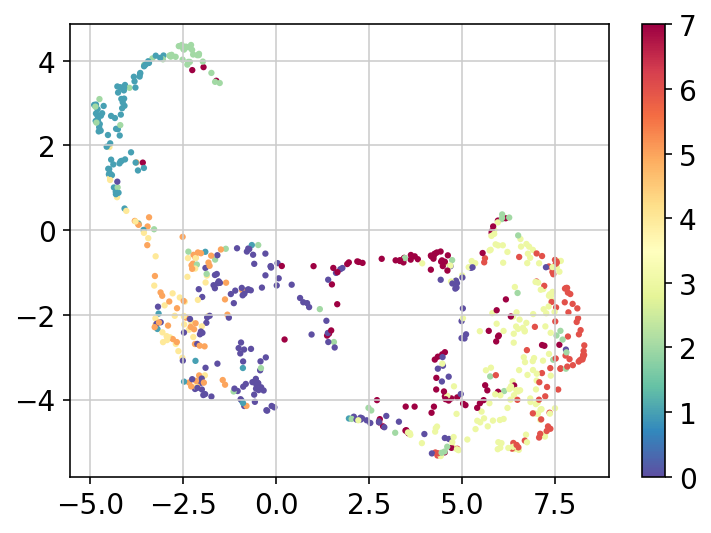

In [7]:
sc.external.pl.sam(a_rep0,projection='X_umap',c='cls_8_pca')

In [9]:
a = []

In [10]:
a[10]=1

IndexError: list assignment index out of range